# Use SAM outputs and perform post-processesing analysis

#### Code created by Ehsan Erfani for UW-SAM, summer 2022 @UW

In [1]:
###### import necessary libraries
import numpy as np # linear algebra
import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
from netCDF4 import Dataset
from math import log10
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

In [2]:
##### Set the parameters and input file names:
## obs and reanalysis
forcing = Dataset('../SEA_STARR_FAST/SEA_STARR_CTRL_SCM_driver_SCAMIOP_Created_20-Jun-2022.nc')

## model runs
file = Dataset('../OUT_STAT/SEA_STARR_FAST_384sqx288_50m_M2005PA_RRTM4PBL_UM5_ProgAer_CTRL_LD.nc')
file1 = Dataset('../OUT_STAT/SEA_STARR_FAST_384sqx288_50m_M2005PA_RRTM4PBL_UM5_ProgAer_NA100_LD.nc')
file2 = Dataset('../OUT_STAT/SEA_STARR_FAST_384sqx288_50m_M2005PA_RRTM4PBL_UM5_ProgAer_NA30_LD.nc')


#file22  = Dataset('../OUT_STAT/SEA_STARR_FAST_120sqx288_50m_M2005PA_RRTM4PBL_UM5_ProgAer_test_CTRL.nc')

## Parameters
myblue1 = (0.31560580108711567, 0.005345691264152297, 0.6167893813265289)
myblue2 = (0, 0.5, 1)
ls = ['-', '--', '-.', ':', '-', '-', '-', '-', '-']  # line styles
fn = [file, file1, file2]
NN = len(fn)
cc = [myblue1   , 'forestgreen', 'crimson', 'deepskyblue', 'hotpink'    ,  'tomato', 'darkgoldenrod']  # colors
lb = [ 'CTRL LD',  'NA100 LD'  , 'NA30 LD'   , '150-40'     , '40-150'     ,  'M-LD'  , 'M'      , 'MX3']  # model labels
lw = ['2', '2', '2', '2', '2', '2', '3', '2']  # linewidth 

init_time = '2017-08-15 00Z' 
Obs_jump= 15
period   = ''
ylim = 4000
#xlim = 3.6
levels = 10 # number of levels above inversion that will be included in MBL averages

In [3]:
## variables in the forcing file:
day    = forcing.variables['day'][:] 
calday = forcing.variables['calday'][:] 
lat    = forcing.variables['lat'][:]             # Surface Latent Heat Flux:
qref   = forcing.variables['qref'][:] * 1000      # Water Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
qt_fo  = forcing.variables['q'][:] * 1000         # Total Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
Tref   = forcing.variables['Tref'][:]             # Absolute Temperature          from from ERA-5: K
SST_fo = forcing.variables['Tg'][:]               # Surface Temperature (SST if over water): K
u_fo   = forcing.variables['u'][:]                # Zonal Wind: m/s
v_fo   = forcing.variables['v'][:]                # Meridional Wind: m/s
ug_fo  = forcing.variables['ug'][:]               # Geostrophic Zonal Wind: m/s
vg_fo  = forcing.variables['vg'][:]               # Geostrophic Meridional Wind: m/s
z_forc = forcing.variables['z'][:]               # Geopotential height from ERA-5:
Na_accm= forcing.variables['Na_accum'][:] / 1e6  # Accumulation mode aerosol number mixing ratio from MERRA2 (Corrected based on regression w/in situ CSET data)
omega  = forcing.variables['omega'][:]           # Vertical Pressure Velocity: Pa/s
fday   = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z_forc[0,:,0,0], fday) # making meshgrid

In [4]:
## original forcing
forcing_orig = Dataset('../SEA_STARR_FAST/SEA_STARR_FAST_SCM_driver.nc')

## variables in the forcing_orig file:
t_mic = forcing_orig.variables['time'][:] 
z_mic = forcing_orig.variables['zh'][:]               
qt_mic= forcing_orig.variables['qt_nud'][:]               
w_mic = forcing_orig.variables['wa'][:]               # upward_air_velocity: m/s 
Na_mic= forcing_orig.variables['na_nud'][:] 

z_mic_mg, t_mic_mg = np.meshgrid(z_mic, t_mic) # making meshgrid

In [5]:
###############################################################
## Define required functions for calculations of variables:

### Calculate inversion height (min of dtheta/dz * dRH/dz)

## find delta after calculating mid-point values
def delta(THETA):
    nz = THETA.shape[1]
    THETAi = np.arange(THETA.shape[0] * (nz+1)).reshape(THETA.shape[0], nz+1).astype(float)
    THETAi[:] = np.nan
    THETAi[:,0] = 0
    THETAi[:,1:nz] = 0.5 * (THETA[:,:nz-1] + THETA[:,1:nz])
    THETAi[:,nz] = 1.5 * THETA[:,nz-1] - 0.5 * THETA[:,nz-2]
    d_THETA = THETAi[:,1:] - THETAi[:,:-1]
    return d_THETA

def inv_h(THETA, RH, dzz, zz):        
    d_THETA = THETA[:,1:] - THETA[:,:-1]
    d_RH = RH[:,1:] - RH[:,:-1]

    ZINV = d_THETA[:,0].copy()
    ZINV[:] = np.nan
    for i in range(d_THETA.shape[0]):
        z  = zz[i,:]  if len(zz.shape) > 1 else zz
        dz = dzz[i,:] if len(zz.shape) > 1 else dzz
        dTHETA_dz = d_THETA[i,:] / dz[1:]
        dRH_dz = d_RH[i,:] / dz[1:]
        dTHETA_dz[dTHETA_dz < 0] = 0
        dRH_dz[dRH_dz > 0] = 0    
        func = dTHETA_dz * dRH_dz
        if len(zz.shape) > 1:
            indx = np.max(np.where(func == np.nanmin(func))[0])
        else:
            indx = np.min(np.where(func == np.nanmin(func))[0])                    
        # approximate func as a parabola around the minimum and find the height where that parabola is minimized. 
        # This will allow the inversion height to vary continuously as the input profiles change.
        # inversion_test is defined at midpoints of grid
        zavg = 0.5 * (z[:-1] + z[1:])
        rnge = range(indx-1, indx+2)
        # we define the parabola, converting from m to km.
        pp = np.polyfit(1e-3 * zavg[rnge], func[rnge], 2)
        # take the derivative of the parabola in coeffient space.
        pp_prime = np.array([2 * pp[0], pp[1]]) # this is its derivative
        # find the zero-crossing of the derivative. This is the inversion height in meters
        z_inv = -1e3 * pp_prime[1] / pp_prime[0]         
        ZINV[i] = z_inv
    return ZINV

# calc. Accumulated Precip.
def calc_acc_R(R):
    acc_R = R.copy()
    acc_R[:] = np.nan
    for i in range(len(acc_R)):
        acc_R[i] = np.nansum(R[:i+1]) / (time[-1] * 24) 
    return acc_R

# Calc. LTS
def calc_LTS(THETA, P):
    indx = np.where((P <= 701) & (P >= 699))[0]
    
    theta_700 = np.nanmean(THETA[:,indx], 1)
    theta_sfc = THETA[:, 0]
    LTS = theta_700 - theta_sfc
    return LTS

def mbl_ave_N(NA, RHO, dz, inv_idx):
    integ_NA_BL = NA[:,0].copy()    
    integ_NA_BL[:] = np.nan
    for i in range(NA[:,0].size):
        dz2 = dz.copy()
        mmm = np.where(np.isnan(NA[i,:]) == 1)[0]
        if len(mmm) > 0:
            dz2[mmm] = np.nan
        mmm2 = np.where(NA[i,:] <= 1)[0]
        if (len(mmm2) > 0 and len(mmm2) != len(NA)):
            dz2[mmm2] = np.nan            
        integ_NA_BL[i] = np.nansum(RHO[i,:inv_idx[i]] * dz2[:inv_idx[i]] * NA[i,:inv_idx[i]]) / np.nansum(RHO[i,:inv_idx[i]] * dz2[:inv_idx[i]])
    return integ_NA_BL

def mbl_ave_flight(RFin_alt, RFin_N, RFin_RHO, iii, ZINV):
    if iii >= len(ZINV):
        jjj = np.where(abs(RFin_alt - ZINV[-1]) == np.nanmin(abs(RFin_alt - ZINV[-1])))[0][0]
    else:
        jjj = np.where(abs(RFin_alt - ZINV[iii]) == np.nanmin(abs(RFin_alt - ZINV[iii])))[0][0]
    RFin_alt_diff = RFin_alt[:-1] - RFin_alt[1:]
    RFin_alt_diff2= RFin_alt_diff.copy()
    mmm = np.where(np.isnan(RFin_N[1:]) == 1)[0]
    RFin_alt_diff2[mmm] = np.nan
    mmm2 = np.where(RFin_N[1:] <= .5)[0]
    RFin_alt_diff2[mmm2] = np.nan
    RFin_N_mean = np.nansum(RFin_RHO[jjj:] * RFin_N[jjj:] * RFin_alt_diff2[jjj-1:]) / np.nansum(RFin_alt_diff2[jjj-1:] * RFin_RHO[jjj:])
    return RFin_N_mean

def mbl_ave_MERRA(MERRA_Na, ZINV):
    MERRA_Na_mean2 = MERRA_Na[:,0].copy()
    MERRA_Na_mean2[:] = np.nan
    for i in range(MERRA_Na_mean2.size):
        MERRA_Na_mean2[i] = mbl_ave_flight(MERRA_H[i,:], MERRA_Na[i,:], MERRA_RHO[i,:], iii_MERRA[i], ZINV)
    return MERRA_Na_mean2

def calc_Forcing_RHO(z, RHO, MERRA_H, iii):
    Forcing_RHO = MERRA_H.copy()
    Forcing_RHO[:] = np.nan    
    for i in range(MERRA_H.shape[0]):
        f_RHO = interpolate.interp1d(z[::-1], RHO[iii[0],:][::-1])
        indx2 = np.where(MERRA_H[i,:] > z.max())[0]
        if len(indx2) > 0:
            indx = indx2[-1]
            Forcing_RHO[i, indx+1:] = f_RHO(np.array(MERRA_H[i, indx+1:]))
            Forcing_RHO[i, :indx+1] = Forcing_RHO[i, indx+1]
        else:
            Forcing_RHO[i, :] = f_RHO(np.array(MERRA_H[i,:]))
    return Forcing_RHO

def mbl_ave_Forcing(MERRA_Na, ZINV):
    MERRA_Na_mean2 = MERRA_Na[:,0].copy()
    MERRA_Na_mean2[:] = np.nan
    for i in range(MERRA_Na_mean2.size):
        MERRA_Na_mean2[i] = mbl_ave_flight(z_forc[i,:,0,0], MERRA_Na[i,:], Forcing_RHO[i,:], iii_Forcing[i], ZINV)
    return MERRA_Na_mean2

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [6]:
def read_model_vars(file):
    ## model variables:
    TIME = file.variables['time'][:]
    # 1-D variables
    z       = file.variables['z'][:]
    SST     = file.variables['SST'][:] - 273.15     # sea surface temperature converted from kelvin to celcius unit
    SSTOBS  = file.variables['SSTOBS'][:] - 273.15 
    PREC    = file.variables['PREC'][:]             # Surface Precipitation"  "mm/day" 
    LHF     = file.variables['LHF'][:]
    LHFOBS  = file.variables['LHFOBS'][:]
    SHF     = file.variables['SHF'][:]
    SHFOBS  = file.variables['SHFOBS'][:]
    Ps      = file.variables['Ps'][:]
    LWNS    = file.variables['LWNS'][:]
    SWNS    = file.variables['SWNS'][:]
    RWP     = file.variables['RWP'][:]       # Rain Water Path: g/m2
    CWP     = file.variables['CWP'][:]       # Cloud Water Path
    LWP     = file.variables['LWP'][:]       # GCSS Liquid Water Path
    MODISLWP= file.variables['MODISLWP'][:]
    CLDLOW  = file.variables['CLDLOW'][:]
    # SAM's CLDLOW variable uses a threshold for cloud fraction that is based on LWP (20 g/m2, when CEM=.true., as in these runs) 
    # which may not be consistent with an optical-depth-based threshold, as would be used in a satellite product.
    CLDMID  = file.variables['CLDMID'][:]
    CLDHI   = file.variables['CLDHI'][:]
    MODISREL= file.variables['MODISREL'][:]   # MODIS Effective Radius (Liquid): mkm
    ISCCPLOW= file.variables['ISCCPLOW'][:] 
    # The ISCCP simulator approximates the cloud fraction that would be observed by a satellite using an optical depth threshold
    # of 0.3. The model domain includes only the lower troposphere, so that the relevant ISCCPTOT and ISCCPLOW should be identical.  
    ISCCPTOT= file.variables['ISCCPTOT'][:] # 
    ZINV_org= file.variables['ZINV'][:]       # inversion height (km)
    WMAX    = file.variables['WMAX'][:]       # max updraft vel. (m/s)
    LWNTOA  = file.variables['LWNTOA'][:]     # Net LW flux at TOA (w/m2)
    SWNTOA  = file.variables['SWNTOA'][:]     # Net SW flux at TOA (w/m2)
    SOLIN   = file.variables['SOLIN'][:]      # Incoming SW flux at TOA (w/m2)
    ISCCPALB= file.variables['ISCCPALB'][:]   # ISCCP Cloud Albedo
    SWNTOAC = file.variables['SWNTOAC'][:]    # Net SW flux at TOA (Clear Sky)
    LWNTOAC = file.variables['LWNTOAC'][:]    # Net LW flux at TOA (Clear Sky)
    MODISTAU= file.variables['MODISTAU'][:]   # MODIS Cloud Optical Path
    ISCCPTAU= file.variables['ISCCPTAU'][:]   # ISCCP Optical Path
    TAUQCacc= file.variables['TAUQC'][:]      # Approx optical depth of cloud liquid water
    TAUQRacc= file.variables['TAUQR'][:]      # Approx optical depth of RAIN
    QCOEFFR = file.variables['QCOEFFR'][:]    # Mixing ratio of QC over effective radius, EFFR = QC/QCOEFFR: g/kg/micro

    time   = TIME - int(TIME[0])
    SOLIN2 = SOLIN.copy()
    SOLIN2[SOLIN2 <= 100] = np.nan
    albedo = (SOLIN2 - SWNTOA) / SOLIN2
    albd_clear = (SOLIN2 - SWNTOAC) / SOLIN2
    SW_CRE  = SWNTOA - SWNTOAC
    LW_CRE  =-LWNTOA + LWNTOAC
    net_CRE = SW_CRE + LW_CRE

    #2-D variables:
    NAd    = file.variables['NAd'][:]      # dry aerosol number concentration (#/mg)
    NC     = file.variables['NCCLD'][:]    # cloud number concentration in cloud
    NCORIG = file.variables['NC'][:]       # cloud number concentration
    NR     = file.variables['NRCLD'][:]    # RAIN NUMBER CONCENTRATION in cloud
    NRORIG = file.variables['NR'][:]       # RAIN NUMBER CONCENTRATION
    RHO    = file.variables['RHO'][:]      # kg/m3
    CLD    = file.variables['CLD'][:]      # cloud Fraction
    RWC    = file.variables['QPCLD'][:]    # rain water and snow content: g/kg
    CWC    = file.variables['QNCLD'][:]    # cloud water and cloud ice content in cloud: g/kg
    QCCLD  = file.variables['QCCLD'][:]    # Cloud liquid water mixing ratio in cloud
    QCOND  = file.variables['QCOND'][:]    # Total Condensate: g/kg
    WOBS   = file.variables['WOBS'][:]     # large scale W: m/s
    TABS   = file.variables['TABS'][:]     # Absolute temperature: K
    QT     = file.variables['QT'][:]       # Total water (no rain/snow included): g/kg
    QV     = file.variables['QV'][:]       # Water vapor: g/kg
    RH     = file.variables['RELH'][:]     # RH: %
    THETA  = file.variables['THETA'][:]    # THETA: K
    U      = file.variables['U'][:]        # x wind component: m/s
    V      = file.variables['V'][:]        # y wind component: m/s
    P      = file.variables['p'][:]        # pressure
    PRECIP = file.variables['PRECIP'][:]   # precipitation flux: mm/day
    W2     = file.variables['W2'][:]       # Variance of the z wind component: m2/s2
    THETAL = file.variables['THETAL'][:]    # Liquid water potential temperature: K

    QAd    = file.variables['QAd'][:] # DRY AEROSOL MASS: g/kg
    QAw    = file.variables['QAw'][:] # WET AEROSOL MASS
    QCORIG = file.variables['QC'][:] # Cloud liquid water mass mixing ratio: g/kg
    QRORIG = file.variables['QR'][:] # RAIN
    QAr    = file.variables['QAr'][:] # RAIN AEROSOL MASS
    QA     = QAd + QAw + QCORIG + QRORIG + QAr

    # Aerosol budget terms:
    # NC:
    NCSTRG  = file.variables['NCSTRG'][:] # Storage of Cloud Water NUMBER CONCENTRATION: #/mg/day
    NCADV   = file.variables['NCADV'][:]  # Tendency of Cloud Water NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
    NCDIFF  = file.variables['NCDIFF'][:] # Tendency of Cloud Water NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
    NCLSADV = file.variables['NCLSADV'][:]# Tendency of Cloud Water NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
    NCSED   = file.variables['NCSED'][:]  # Tendency of Cloud Water NUMBER CONCENTRATION due to sedimentation: #/mg/day
    NCMPHY  = file.variables['NCMPHY'][:] # Tendency of CLOUD WATER NUMBER CONCENTRATION due to microphysical processes: #/mg/day
    NCFLXS  = file.variables['NCFLXS'][:] # Subgrid flux of CLOUD WATER NUMBER CONCENTRATION: #/mg/day
    # NAd:
    try:
        NAdSTRG = file.variables['NAcSTRG'][:] - NCSTRG  # Storage of DRY AEROSOL NUMBER CONCENTRATION: #/mg/day
        NAdADV  = file.variables['NAcADV'][:] - NCADV    # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
        NAdDIFF = file.variables['NAcDIFF'][:] - NCDIFF  # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
        NAdLSADV= file.variables['NAcLSADV'][:] - NCLSADV# Tendency of DRY AEROSOL NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
        NAdSED  = file.variables['NAcSED'][:] - NCSED    # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to sedimentation: #/mg/day
        NAdMPHY = file.variables['NAcMPHY'][:] - NCMPHY  # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to microphysical processes: #/mg/day
        NAdFLXS = file.variables['NAcFLXS'][:] - NCFLXS  # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
    except:
        NAdSTRG = file.variables['NAdSTRG'][:] # Storage of DRY AEROSOL NUMBER CONCENTRATION: #/mg/day
        NAdADV  = file.variables['NAdADV'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
        NAdDIFF = file.variables['NAdDIFF'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
        NAdLSADV= file.variables['NAdLSADV'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
        NAdSED  = file.variables['NAdSED'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to sedimentation: #/mg/day
        NAdMPHY = file.variables['NAdMPHY'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to microphysical processes: #/mg/day
        NAdFLXS = file.variables['NAdFLXS'][:] # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
    SCVTNADC= file.variables['SCVTNADC'][:]          # Tendency of NAD due to interstitial scavenging by cloud: #/mg/day
    SCVTNADR= file.variables['SCVTNADR'][:]          # Tendency of NAD due to interstitial scavenging by rain: #/mg/day
    # NR:
    NRSTRG  = file.variables['NRSTRG'][:]    # Storage of Rain NUMBER CONCENTRATION: #/mg/day
    NRADV   = file.variables['NRADV'][:]     # Tendency of Rain NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
    NRDIFF  = file.variables['NRDIFF'][:]    # Tendency of Rain NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
    NRLSADV = file.variables['NRLSADV'][:]   # Tendency of Rain NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
    NRSED   = file.variables['NRSED'][:]     # Tendency of Rain NUMBER CONCENTRATION due to sedimentation: #/mg/day
    NRMPHY  = file.variables['NRMPHY'][:]    # Tendency of Rain NUMBER CONCENTRATION due to microphysical processes: #/mg/day
    NCSTEN  = file.variables['NCSTEN'][:]    # CHANGE IN CLOUD DROPLET NUMBER DUE TO SEDIMENTATION: #/mg/day
    NRSTEN  = file.variables['NRSTEN'][:]    # CHANGE IN RAIN NUMBER DUE TO SEDIMENTATION: #/mg/day
    NPRA_pos= file.variables['NPRA'][:]      # CHANGE IN RAIN NUMBER DUE TO ACCRETION OF CLOUD DROPLETS: #/mg/day
    NPRC    = file.variables['NPRC'][:]      # CHANGE NC AUTOCONVERSION DROPLETS: #/mg/day
    NPRC1   = file.variables['NPRC1'][:]     # CHANGE NR AUTOCONVERSION DROPLETS: #/mg/day
    NCPOSLIM= file.variables['NCPOSLIM'][:]  # CHANGE IN CLOUD DROPLET NUMBER DUE TO POSITIVE LIMITING: #/mg/day
    NCNEGLIM= file.variables['NCNEGLIM'][:]  # CHANGE IN CLOUD DROPLET NUMBER DUE TO NEGATIVE LIMITING: #/mg/day
    NRPOSLIM= file.variables['NRPOSLIM'][:]  # CHANGE IN RAIN DROPLET NUMBER DUE TO POSITIVE LIMITING: #/mg/day
    NRNEGLIM= file.variables['NRNEGLIM'][:]  # CHANGE IN RAIN DROPLET NUMBER DUE TO NEGATIVE LIMITING: #/mg/day

    LWC = RWC + CWC
    time_mg, z_mg = np.meshgrid(time, z) # making meshgrid

    cld = CLDLOW.copy()
    cld[:] = np.nan
    for i in range(len(CLDLOW)):
        cld[i] = np.max(CLDLOW[i] + CLDMID[i] + CLDHI[i])

    # calculate accumulated precipitation    
    acc_prec = PREC.copy()
    acc_prec[:] = np.nan
    for i in range(len(acc_prec)):
        acc_prec[i] = np.nansum(PREC[:i+1]) / (time[-1] * 24) 

    # calculate surface wind magnitude
    sfc_wnd = (U[:,0] ** 2 + V[:,0] ** 2) ** 0.5
        
    # SAM outputs only give the heights of cell centers.  
    # To compute a vertical integral, you need the cell interface heights (i.e., the w levels):
    nz = len(z)
    zi = np.arange(nz+1).astype(float)
    zi[:] = np.nan
    zi[0] = 0
    zi[1:nz] = 0.5 * (z[:nz-1] + z[1:nz])
    zi[nz] = 1.5 * z[nz-1] - 0.5 * z[nz-2] 
    dz = zi[1:] - zi[:-1] # Compute the cell thicknesses

    ## Calc. inversion height
    dz3  = z.copy()
    dz3[:] = np.nan
    dz3[1:] = z[1:] - z[:-1]
    ZINV = inv_h(THETAL, RH, dz3, z)
    d_THETA = THETA[:,1:] - THETA[:,:-1]

    
    #################################
    #Calculate the index of BL:
    
    #method1: find index where z is equal to ZINV
    inv_idx = np.arange(len(ZINV))
    inv_idx[:] = int(0)
    for i in range(len(ZINV)):
        diff = abs(z - ZINV[i])
        inv_idx[i] = np.where(diff == np.min(diff))[0][0]  
        
    #method2: find infrc where RH goes below 75%
    inv_idx2 = np.arange(len(ZINV))
    inv_idx2[:] = int(0)
    for i in range(len(ZINV)):
        j = 0
        while (RH[i,j] > 75):
            j += 1
        inv_idx2[i] = j
    # Not very helpful method!

    ### Calc. entrainment:
    entrainment = [] # np.arange(len(ZINV)) #entrainment[:] = int(0)
    for i in range(len(ZINV)):
        entrainment.append(-WOBS[i, inv_idx[i]])
    entrainment = np.array(entrainment) * 1000 # convert to mm/s
    
    ### Marshall-Palmer and other R-Z relations
#    Z = 10 ** (rad_refl_all[:,0] / 10)
#    R_MP = (Z / 200) ** (1/1.6) * 24
#    acc_R_MP = calc_acc_R(R_MP)

#    R_C2004 = (Z / 57) ** (1/1.1) * 24
#    acc_R_C2004 = calc_acc_R(R_C2004)

    LTS = calc_LTS(THETA, P)
    
    #### MBL integral of number concentrations
    NA  = NAd + NCORIG + NRORIG
    #NA  = NAd + NC + NR

    integ_NAd_BL = mbl_ave_N(NAd, RHO, dz, inv_idx)   
    integ_NA_BL  = mbl_ave_N(NA,  RHO, dz, inv_idx)   
    integ_NC_BL  = mbl_ave_N(NC,  RHO, dz, inv_idx)   
    #You have z(1:nz) which are the heights of the cell centers.
    #Compute the interface heights between cells: zi(1) = 0; zi(2:nz) = 0.5*(z(1:nz-1)+z(2:nz)); zi(nz+1) = 1.5*z(nz) - 0.5*z(nz-1)
    #Compute the cell thicknesses: dz(1:nz) = zi(2:nz+1) - zi(1:nz)

    ####
    LWPCLD = mbl_ave_N(LWC, RHO, dz, inv_idx)   

    ### Entrainment and W_lg
    w_ls_inv = -entrainment
    winw   = 2
    entr = ZINV.copy()
    entr[:] = np.nan
    for i in range(len(time)):
        t_entr = 1 / 3
        tind = np.where(abs(time - time[i]) < t_entr / 2)[0]
        p = np.polyfit(time[tind], ZINV[tind], 1)
        entr[i] = 1e3 * p[0] / 86400 - w_ls_inv[i]
    entr = smooth(entr, winw)
    mean_entr= '{:.2f}'.format(np.nanmean(entr))

    #### Calculate turbulence w'2
    W2_Zinv_200    = W2[:,0].copy()
    W2_Zinv_200[:] = np.nan
    for i in range(W2[:,0].size):
        ix_w2 = np.where(abs(ZINV[i] - 200 - z) == np.nanmin(abs(ZINV[i] - 200 - z)))[0]
        W2_Zinv_200[i] = W2[i,ix_w2]

    ### Calculate COD and Re
    def calc_OD(var):
        OD    = var[:,0].copy()
        OD[:] = np.nan
        for i in range(len(OD)):
            idx = np.where(QCCLD[i,:] > 0.01)[0]
            try:
                OD[i] = TAUQCacc[i,np.nanmax(idx)] - TAUQCacc[i,np.nanmin(idx)]
            except:
                pass
        return OD

    rho_idx = 65
    re_2D   = QCORIG / QCOEFFR
    COD = calc_OD(TAUQCacc)
    ROD = calc_OD(TAUQRacc)
    SAM_re = (3. / 2.) * (CWP / ISCCPTOT) / (COD * RHO[:,rho_idx] / ISCCPTOT)

    
    #### Calculate budget terms for aerosol number concentration
    NASTOR  = NAdSTRG + NCSTRG + NRSTRG
    NAEDDY  = NAdADV + NCADV + NRADV + NAdDIFF + NCDIFF + NRDIFF
    NALSADV = NAdLSADV + NCLSADV + NRLSADV
    NASED   = NCSTEN + NRSTEN # NAdSED + NCSED + NRSED 
    NAMPHY  = NAdMPHY + NCMPHY + NRMPHY - NASED
    NASCAV  = - SCVTNADC - SCVTNADR

    NARC = - NPRC - NPRC1
    NPRA = - NPRA_pos
    NALIM = NCPOSLIM - NCNEGLIM + NRPOSLIM - NRNEGLIM
    #d NA = Srf Ad - (ScvCld Ad + ScvRn Ad) - Accr C +  SlfC R - Fallout R + (NMT Ad + NMT C + NMT R)
    NASTOR[NASTOR > 1000] = np.nan
    NASTOR[NASTOR < -1000]  = np.nan
    NARESID = NASTOR - NAEDDY - NALSADV - NASED - NAMPHY - NASCAV
    NARESID[NARESID > 1000] = np.nan
    NARESID[NARESID < -1000]  = np.nan    

    ####
    mass_1500 = np.arange(NAd[:,0].size).astype(float)
    mass_1500[:] = np.nan
    
    i_1500 = np.where((z - 1500) == np.nanmin(abs(z - 1500)))[0][0]

    for i in range(NAd[:,0].size):
        mass_1500[i] = np.nansum( RHO[i,:i_1500] * dz[:i_1500] )

    NASURF_test = 86400 * NAdFLXS[:,0] / (mass_1500 * 1e6) # convert from #/m2/s to #/mg/day


    #########
    def height_Ave(var):
        integ_var = np.arange(var[:,0].size).astype(float)
        integ_var[:] = np.nan
        for i in range(var[:,0].size):
            integ_var[i] = np.nansum(dz[:inv_idx[i]+levels] * RHO[i,:inv_idx[i]+levels] * var[i,:inv_idx[i]+levels])\
            / np.nansum(dz[:inv_idx[i]+levels] * RHO[i,:inv_idx[i]+levels])        
        return integ_var

    height_NASTOR  = height_Ave(NASTOR)
    height_NAEDDY  = height_Ave(NAEDDY) 
    height_NALSADV = height_Ave(NALSADV)
    height_NASED   = height_Ave(NASED)
    height_NAMPHY  = height_Ave(NAMPHY)
    height_NASCAV  = height_Ave(NASCAV)
    height_NARESID = height_Ave(NARESID)
    height_NARC    = height_Ave(NARC)
    height_NALIM   = height_Ave(NALIM)
    height_NPRA    = height_Ave(NPRA)

    MBL_mass = np.arange(NAd[:,0].size).astype(float)
    MBL_mass[:] = np.nan
    for i in range(NAd[:,0].size):
        MBL_mass[i] = np.nansum( RHO[i,:inv_idx[i]+levels] * dz[:inv_idx[i]+levels] )

    height_NASURF = 86400 * NAdFLXS[:,0] / (MBL_mass * 1e6) # convert from #/m2/s to #/mg/day
    height_ENTRNMT = height_NALSADV + height_NAEDDY - height_NASURF

    
    #globals().update(locals())
    return time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST

In [7]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(file1)


upbound = time.copy()
upbound[:] = ylim
upbound[SWNS > 0] = np.nan

xlim  = time[-1]
start = time[0]

## Aerosol Budgets

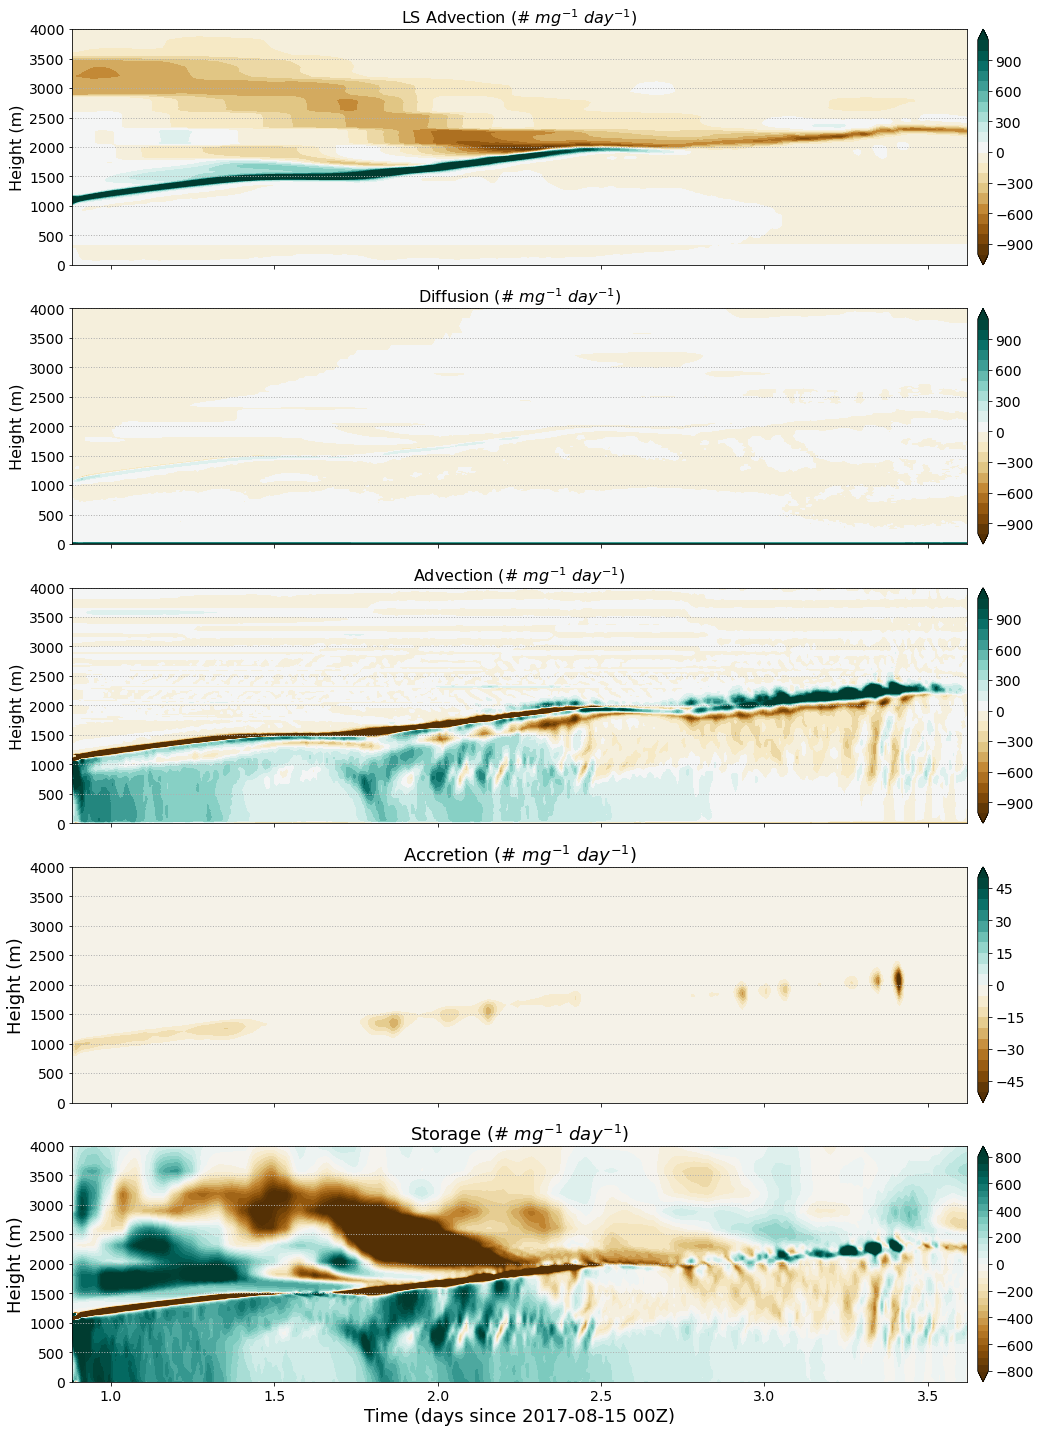

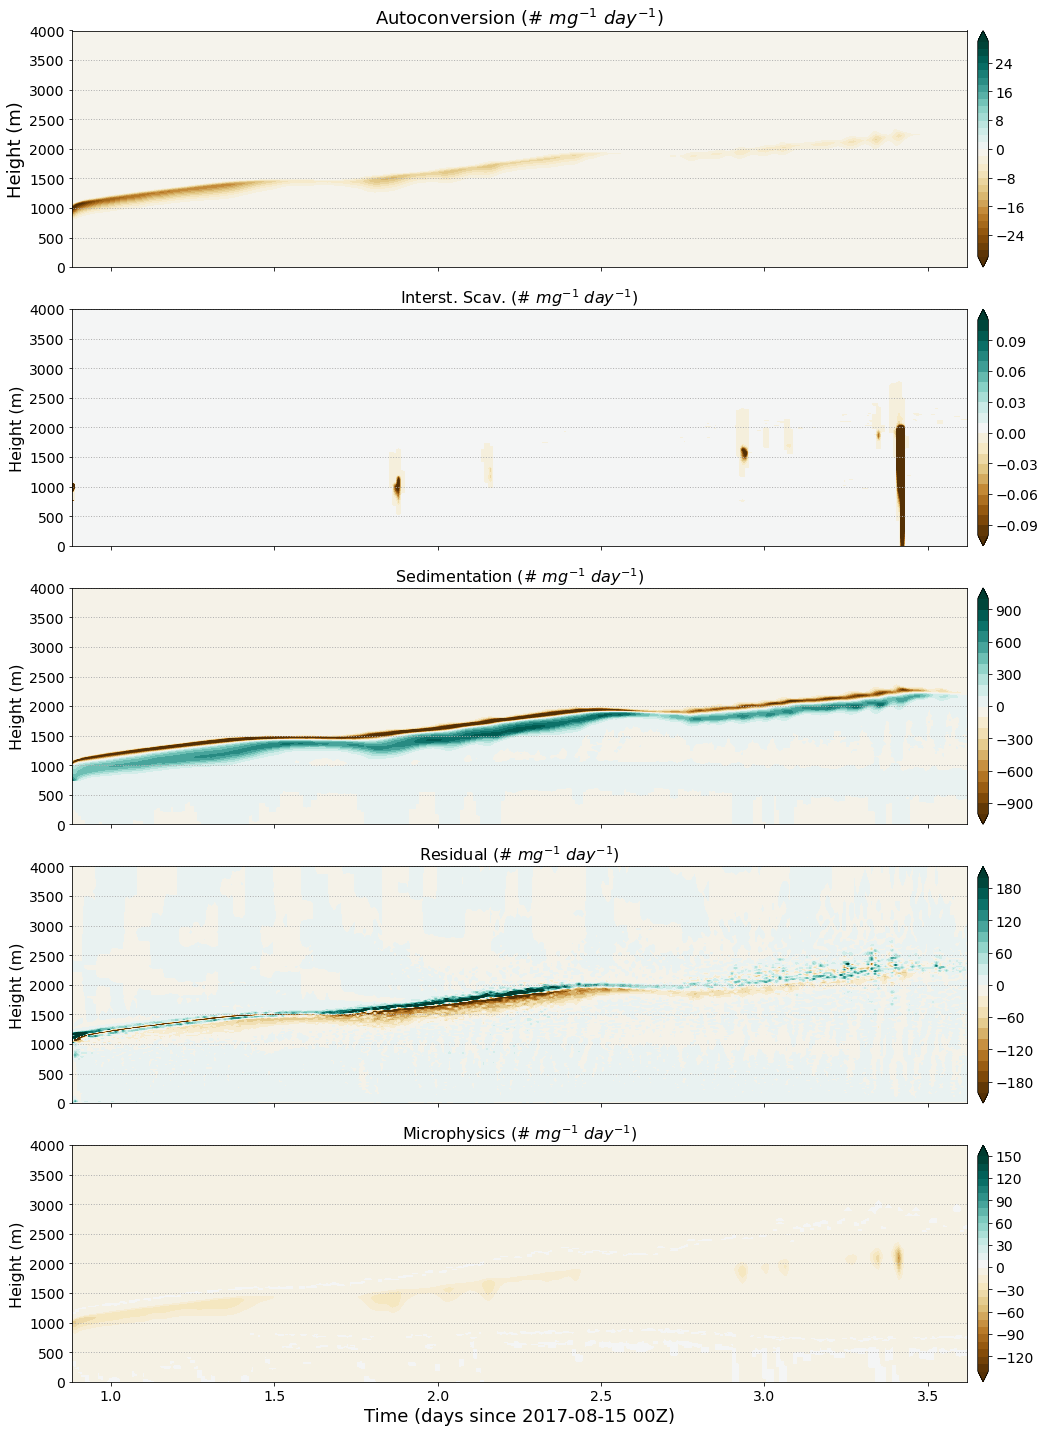

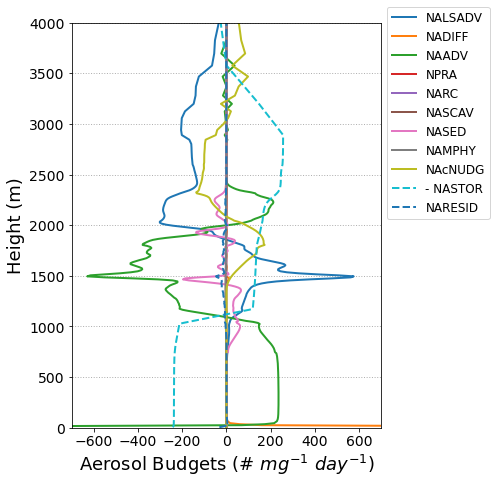

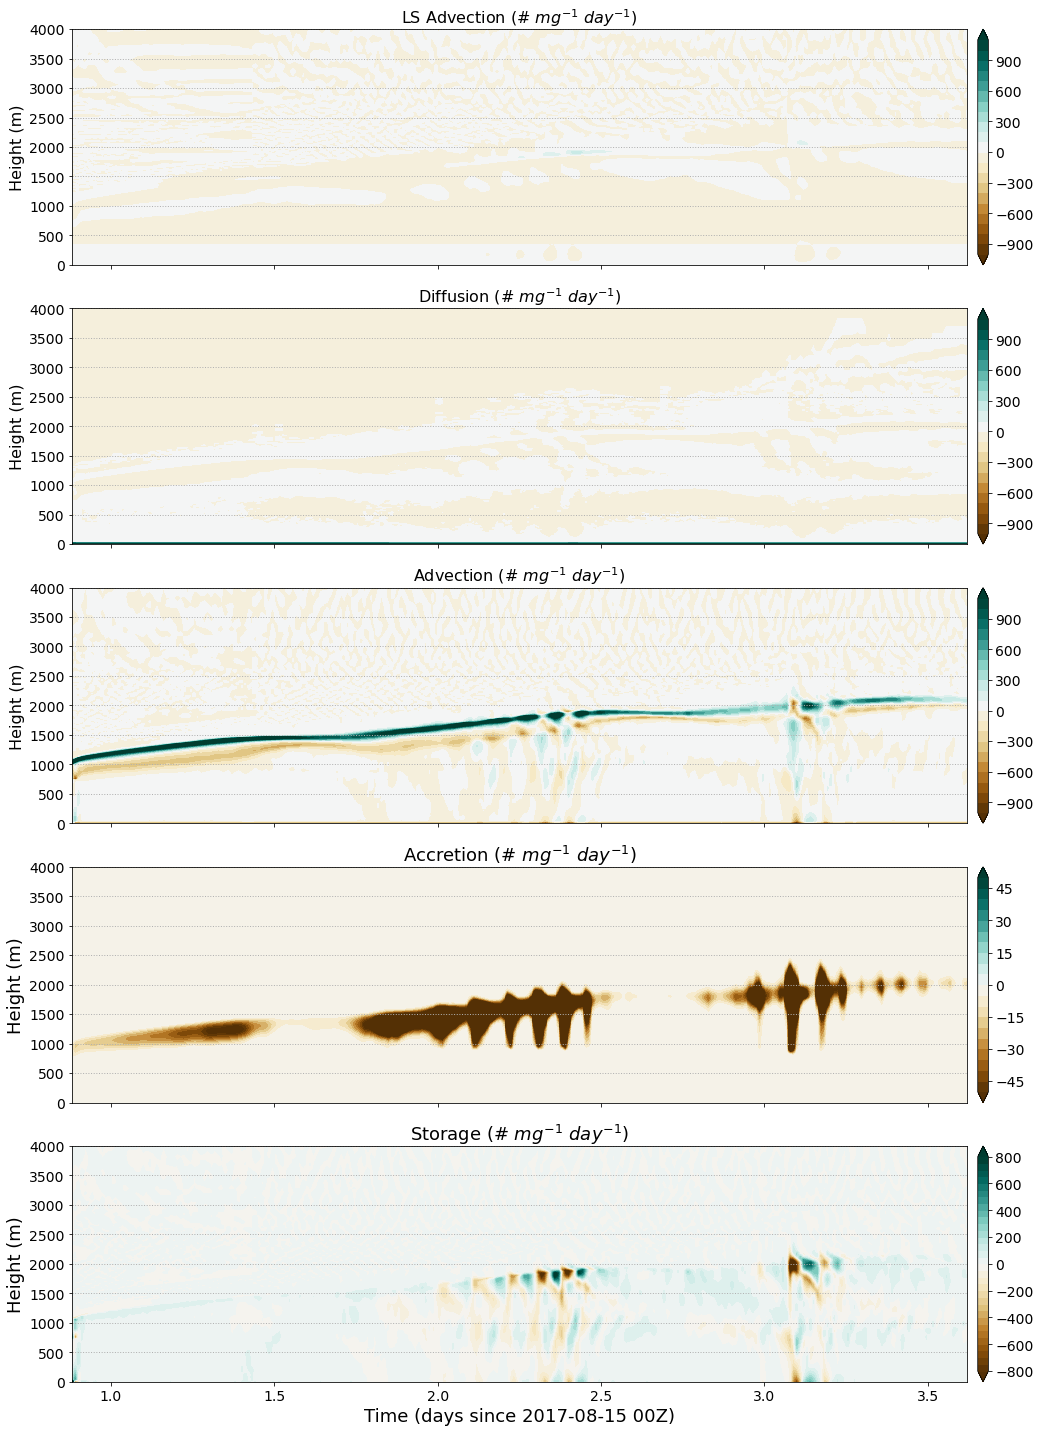

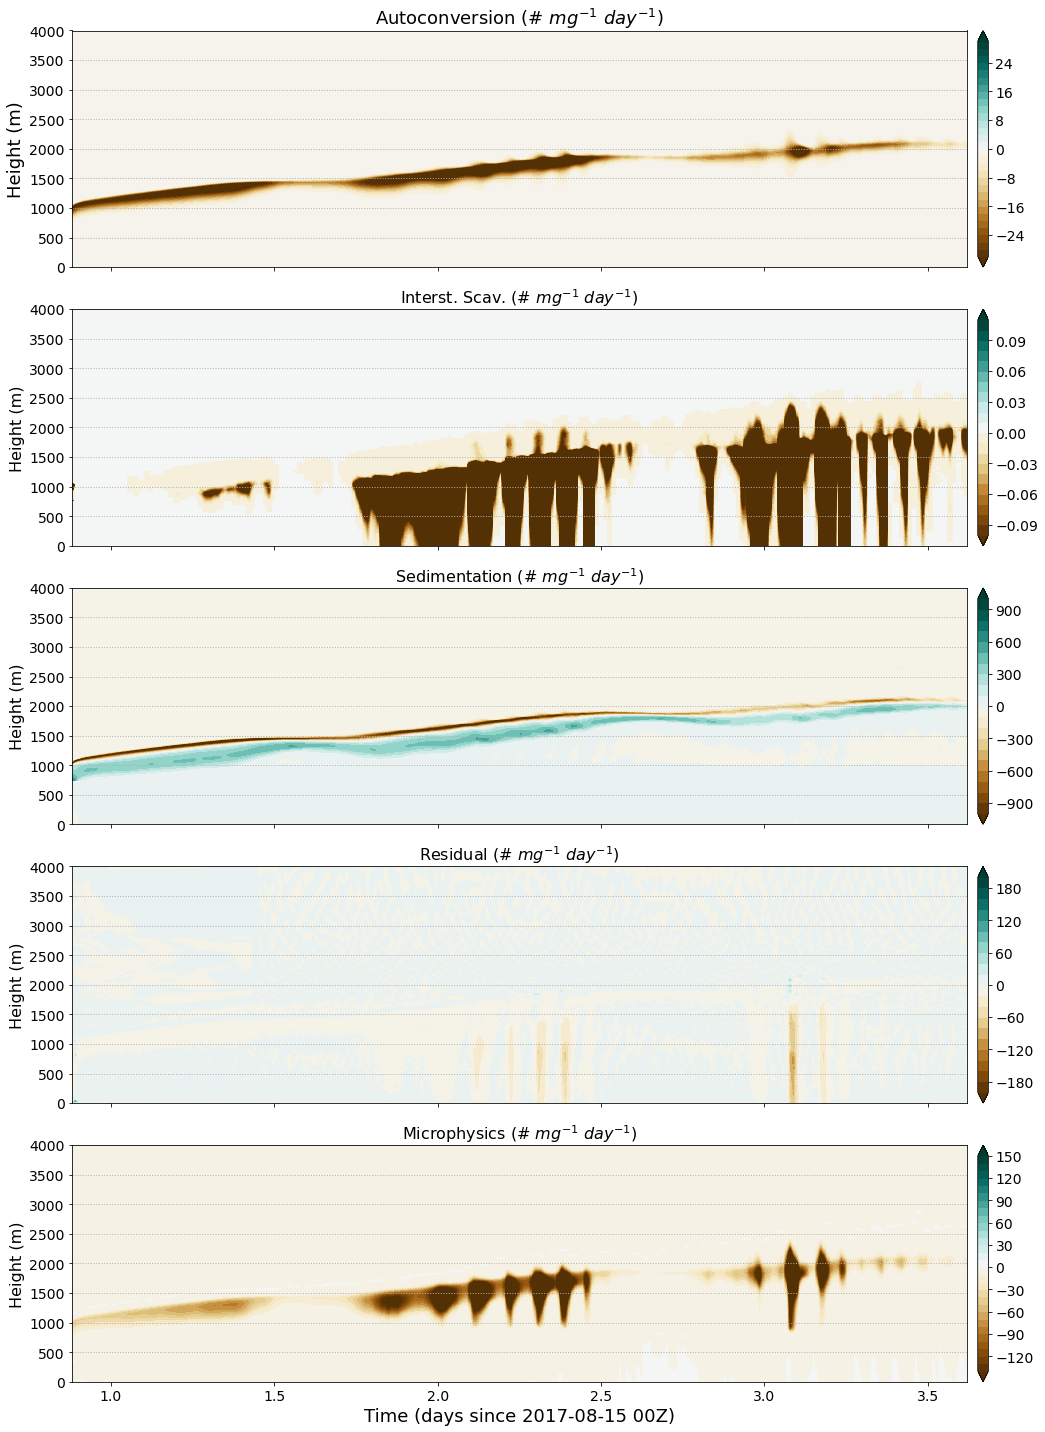

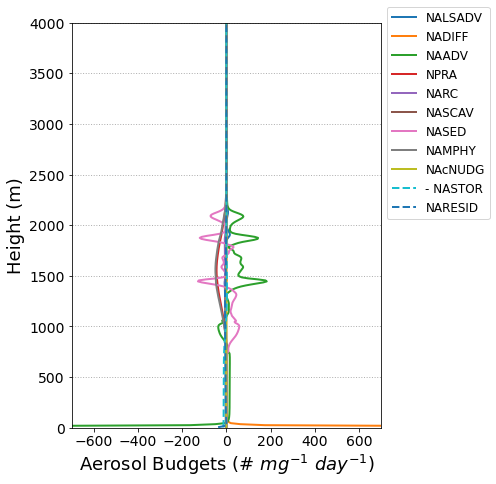

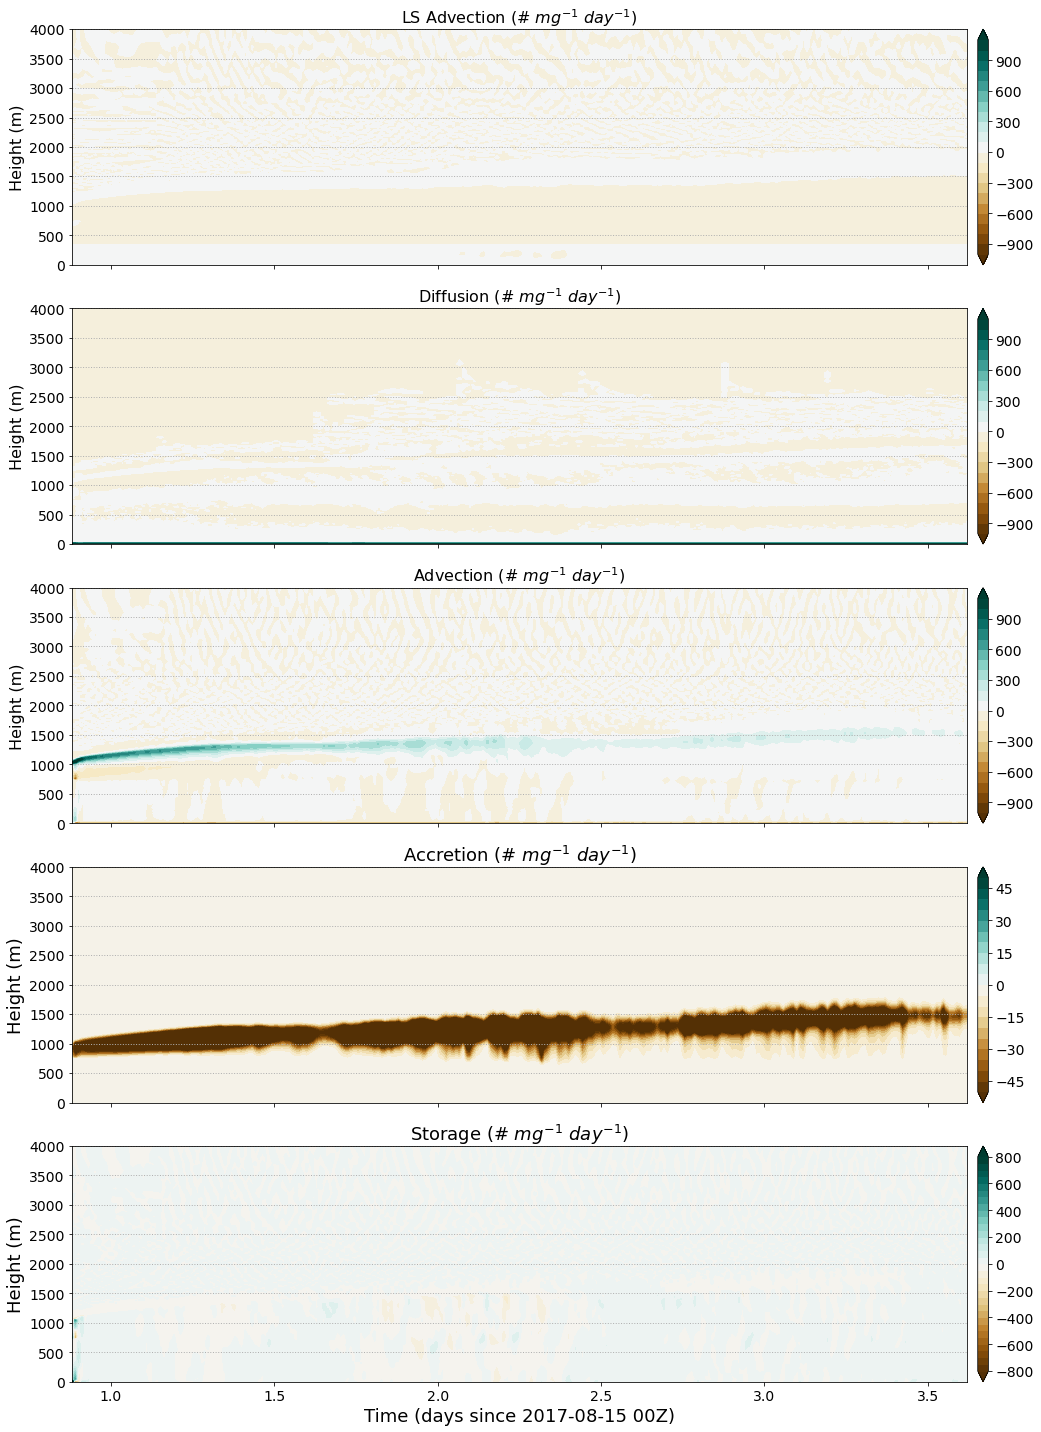

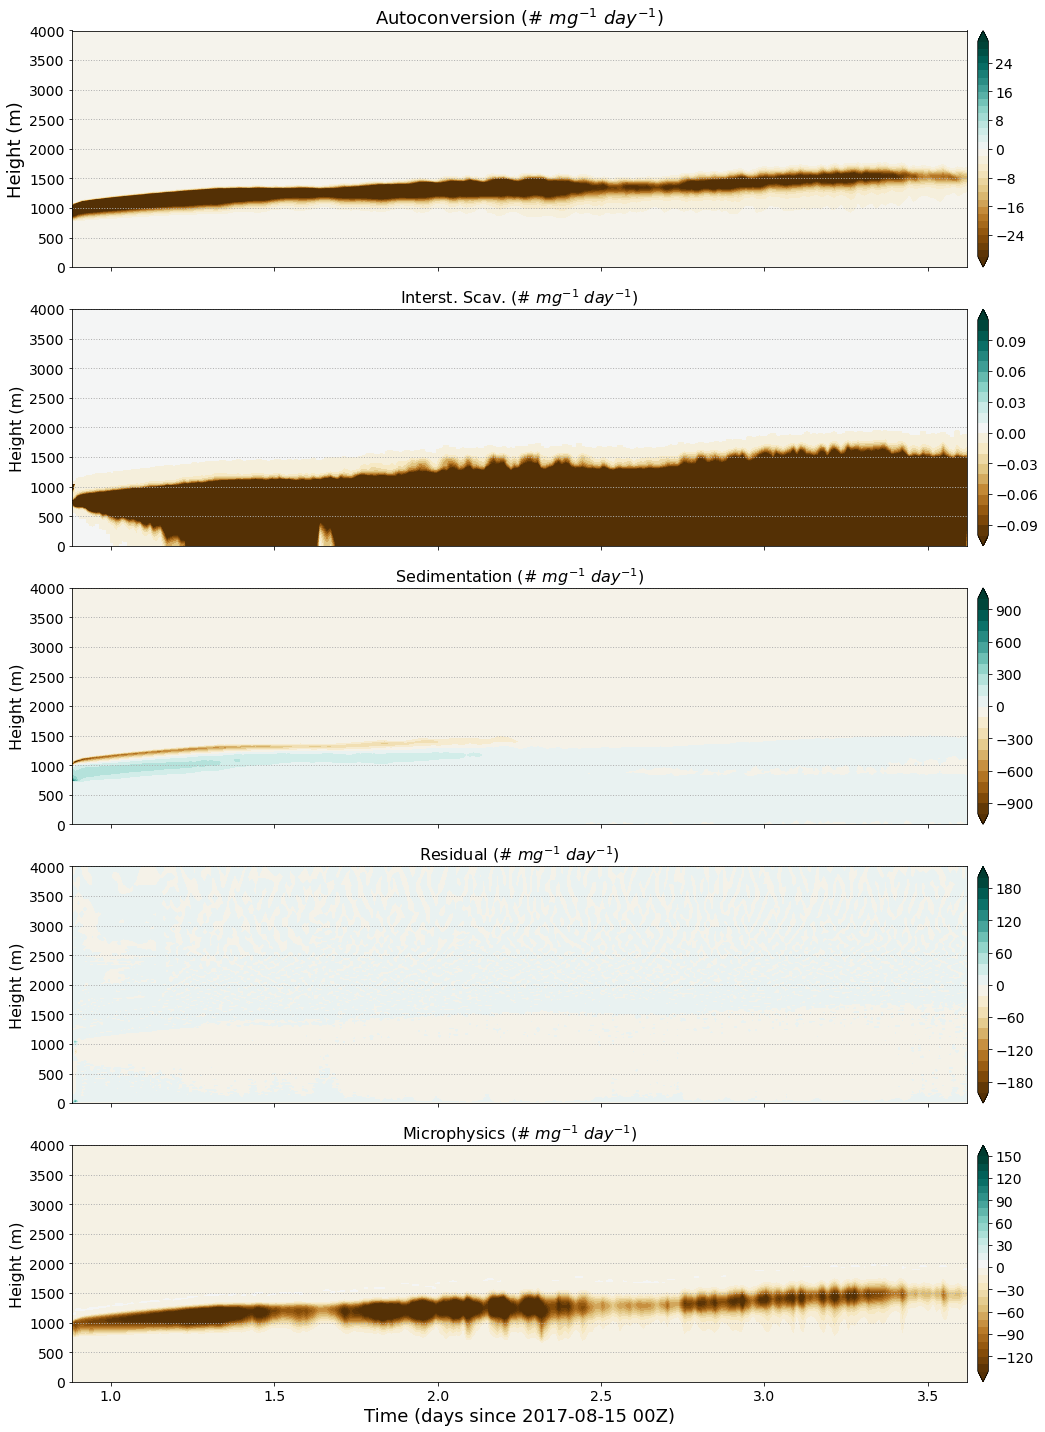

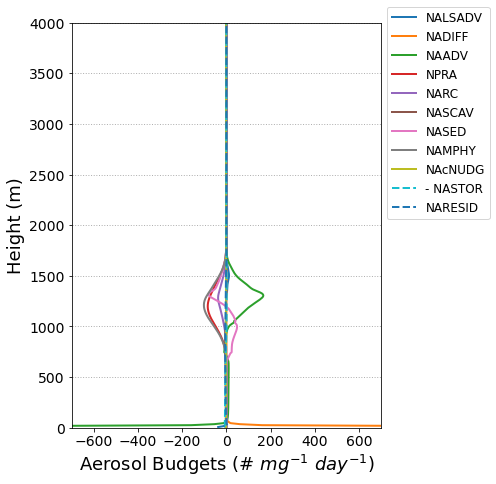

In [8]:
lngh = 15
box = 5

cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])


#######
for jj in range(len(fn)):
    
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
    
    z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

    ######
    # Aerosol budget terms:
    # NAd:
    # NC:
    NCSTRG  = fn[jj].variables['NCSTRG'][:] # Storage of Cloud Water NUMBER CONCENTRATION: #/mg/day
    NCADV   = fn[jj].variables['NCADV'][:]  # Tendency of Cloud Water NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
    NCDIFF  = fn[jj].variables['NCDIFF'][:] # Tendency of Cloud Water NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
    NCLSADV = fn[jj].variables['NCLSADV'][:]# Tendency of Cloud Water NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
    NCSED   = fn[jj].variables['NCSED'][:]  # Tendency of Cloud Water NUMBER CONCENTRATION due to sedimentation: #/mg/day
    NCMPHY  = fn[jj].variables['NCMPHY'][:] # Tendency of CLOUD WATER NUMBER CONCENTRATION due to microphysical processes: #/mg/day
    NCFLXS  = fn[jj].variables['NCFLXS'][:] # Subgrid flux of CLOUD WATER NUMBER CONCENTRATION: #/mg/day
    # NAd:
    try:
        NAdSTRG = fn[jj].variables['NAcSTRG'][:] - NCSTRG  # Storage of DRY AEROSOL NUMBER CONCENTRATION: #/mg/day
        NAdADV  = fn[jj].variables['NAcADV'][:] - NCADV    # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
        NAdDIFF = fn[jj].variables['NAcDIFF'][:] - NCDIFF  # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
        NAdLSADV= fn[jj].variables['NAcLSADV'][:] - NCLSADV# Tendency of DRY AEROSOL NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
        NAdSED  = fn[jj].variables['NAcSED'][:] - NCSED    # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to sedimentation: #/mg/day
        NAdMPHY = fn[jj].variables['NAcMPHY'][:] - NCMPHY  # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to microphysical processes: #/mg/day
        NAdFLXS = fn[jj].variables['NAcFLXS'][:] - NCFLXS  # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
        NAcNUDG = fn[jj].variables['NAcNUDG'][:]           # Tendency of ACCUMULATION MODE AEROSOL NUMBER (=NAd+NC, dry+NC) due to nudging: #/m2/s
    except:
        NAdSTRG = fn[jj].variables['NAdSTRG'][:] # Storage of DRY AEROSOL NUMBER CONCENTRATION: #/mg/day
        NAdADV  = fn[jj].variables['NAdADV'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
        NAdDIFF = fn[jj].variables['NAdDIFF'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
        NAdLSADV= fn[jj].variables['NAdLSADV'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
        NAdSED  = fn[jj].variables['NAdSED'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to sedimentation: #/mg/day
        NAdMPHY = fn[jj].variables['NAdMPHY'][:] # Tendency of DRY AEROSOL NUMBER CONCENTRATION due to microphysical processes: #/mg/day
        NAdFLXS = fn[jj].variables['NAdFLXS'][:] # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
    SCVTNADC= fn[jj].variables['SCVTNADC'][:]          # Tendency of NAD due to interstitial scavenging by cloud: #/mg/day
    SCVTNADR= fn[jj].variables['SCVTNADR'][:]          # Tendency of NAD due to interstitial scavenging by rain: #/mg/day
    # NR:
    NRSTRG  = fn[jj].variables['NRSTRG'][:]    # Storage of Rain NUMBER CONCENTRATION: #/mg/day
    NRADV   = fn[jj].variables['NRADV'][:]     # Tendency of Rain NUMBER CONCENTRATION due to resolved vertical advection: #/mg/day
    NRDIFF  = fn[jj].variables['NRDIFF'][:]    # Tendency of Rain NUMBER CONCENTRATION due to vertical SGS transport: #/mg/day
    NRLSADV = fn[jj].variables['NRLSADV'][:]   # Tendency of Rain NUMBER CONCENTRATION due to large-scale vertical advecti: #/mg/day
    NRSED   = fn[jj].variables['NRSED'][:]     # Tendency of Rain NUMBER CONCENTRATION due to sedimentation: #/mg/day
    NRMPHY  = fn[jj].variables['NRMPHY'][:]    # Tendency of Rain NUMBER CONCENTRATION due to microphysical processes: #/mg/day
    NCSTEN  = fn[jj].variables['NCSTEN'][:]    # CHANGE IN CLOUD DROPLET NUMBER DUE TO SEDIMENTATION: #/mg/day
    NRSTEN  = fn[jj].variables['NRSTEN'][:]    # CHANGE IN RAIN NUMBER DUE TO SEDIMENTATION: #/mg/day
    NPRA_pos= fn[jj].variables['NPRA'][:]      # CHANGE IN RAIN NUMBER DUE TO ACCRETION OF CLOUD DROPLETS: #/mg/day
    NPRC    = fn[jj].variables['NPRC'][:]      # CHANGE NC AUTOCONVERSION DROPLETS: #/mg/day
    NPRC1   = fn[jj].variables['NPRC1'][:]     # CHANGE NR AUTOCONVERSION DROPLETS: #/mg/day
    NCPOSLIM= fn[jj].variables['NCPOSLIM'][:]  # CHANGE IN CLOUD DROPLET NUMBER DUE TO POSITIVE LIMITING: #/mg/day
    NCNEGLIM= fn[jj].variables['NCNEGLIM'][:]  # CHANGE IN CLOUD DROPLET NUMBER DUE TO NEGATIVE LIMITING: #/mg/day
    NRPOSLIM= fn[jj].variables['NRPOSLIM'][:]  # CHANGE IN RAIN DROPLET NUMBER DUE TO POSITIVE LIMITING: #/mg/day
    NRNEGLIM= fn[jj].variables['NRNEGLIM'][:]  # CHANGE IN RAIN DROPLET NUMBER DUE TO NEGATIVE LIMITING: #/mg/day

    #### Calculate budget terms for aerosol number concentration
    NASTOR  = NAdSTRG + NCSTRG + NRSTRG
    NAEDDY  = NAdADV + NCADV + NRADV + NAdDIFF + NCDIFF + NRDIFF
    NAADV   = NAdADV + NCADV + NRADV
    NADIFF  = NAdDIFF + NCDIFF + NRDIFF
    NALSADV = NAdLSADV + NCLSADV + NRLSADV
    NASED   = NCSTEN + NRSTEN # NAdSED + NCSED + NRSED 
    NAMPHY  = NAdMPHY + NCMPHY + NRMPHY - NASED
    NASCAV  = - SCVTNADC - SCVTNADR

    NARC = - NPRC - NPRC1
    NPRA = - NPRA_pos
    NALIM = NCPOSLIM - NCNEGLIM + NRPOSLIM - NRNEGLIM
    NARESID = NASTOR - NAEDDY - NALSADV - NASED - NAMPHY - NASCAV
    NARESID_2 = NASTOR - NAEDDY - NALSADV - NASED - NAMPHY - NAcNUDG
    
    #############    
    fig, axis = plt.subplots(5, 1,figsize=(16,20))

    i = 0
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('LS Advection (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 1
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Diffusion (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 2
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Advection (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 3
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('Accretion (# $mg^{-1}$ $day^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 4
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('Storage (# $mg^{-1}$ $day^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)
    
    ##########
    i = 0
    clevs = np.arange(-1000, 1200, 100)
    cc1 = axis[i].contourf(time_mg, z_mg, NALSADV, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 1
    clevs = np.arange(-1000, 1200, 100)
    cc1 = axis[i].contourf(time_mg, z_mg, NADIFF, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 2
    clevs = np.arange(-1000, 1200, 100)
    cc1 = axis[i].contourf(time_mg, z_mg, NAADV, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 3
    clevs = np.arange(-50, 55, 5)
    cc1 = axis[i].contourf(time_mg, z_mg, NPRA, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 4
    clevs = np.arange(-800, 850, 50)
    cc1 = axis[i].contourf(time_mg, z_mg, NASTOR, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)


    plt.tight_layout(w_pad=1)
    plt.show()
    

    ###########################
    fig, axis = plt.subplots(5, 1,figsize=(16,20))

    i = 0
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('Autoconversion (# $mg^{-1}$ $day^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)
    #axis[i].axes.get_xaxis().set_visible(False)

    i = 1
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Interst. Scav. (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 2
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Sedimentation (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 3
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Residual (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 4
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('Microphysics (# $mg^{-1}$ $day^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    ######
    i = 0
    clevs = np.arange(-30, 32, 2)
    cc1 = axis[i].contourf(time_mg, z_mg, NARC, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 1
    clevs = np.arange(-.1, 0.12, .01)
    cc1 = axis[i].contourf(time_mg, z_mg, NASCAV, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 2
    clevs = np.arange(-1000, 1100, 100)
    cc1 = axis[i].contourf(time_mg, z_mg, NASED, clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)

    i = 3
    clevs = np.arange(-200, 220, 20)
    cc1 = axis[i].contourf(time_mg, z_mg, NARESID_2, clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)

    i = 4
    clevs = np.arange(-140, 160, 10)
    cc1 = axis[i].contourf(time_mg, z_mg, NAMPHY, clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)
    
    plt.tight_layout(w_pad=1)
    plt.show()
    
    
    ########
    fig, axis = plt.subplots(1, 1,figsize=(7,7))

    i = 0
    axis.set_ylabel('Height (m)', fontsize = '18')
    axis.set_xlabel('Aerosol Budgets (# $mg^{-1}$ $day^{-1}$)', fontsize = '18')
    axis.set_xlim([-700, 700])
    axis.set_ylim([0, ylim])
    axis.tick_params(axis='both', which='major', labelsize=14)
    axis.grid(linestyle=':', axis='y', linewidth=1)

    axis.plot(np.nanmean(NALSADV,0), z, linewidth= lw[jj], label='NALSADV')
    axis.plot(np.nanmean(NADIFF,0), z, linewidth= lw[jj], label='NADIFF')
    axis.plot(np.nanmean(NAADV,0), z, linewidth= lw[jj], label='NAADV')
    axis.plot(np.nanmean(NPRA,0), z, linewidth= lw[jj], label='NPRA')
    axis.plot(np.nanmean(NARC,0), z, linewidth= lw[jj], label='NARC')
    axis.plot(np.nanmean(NASCAV,0), z, linewidth= lw[jj], label='NASCAV')
    axis.plot(np.nanmean(NASED,0), z, linewidth= lw[jj], label='NASED')
    axis.plot(np.nanmean(NAMPHY,0), z, linewidth= lw[jj], label='NAMPHY')
    axis.plot(np.nanmean(NAcNUDG,0), z, linewidth= lw[jj], label='NAcNUDG')

    axis.plot(np.nanmean(-NASTOR,0), z, '--', linewidth= lw[jj], label='- NASTOR')
    axis.plot(np.nanmean(NARESID_2,0), z, '--', linewidth= lw[jj], label='NARESID')

    axis.legend(fontsize = '12', bbox_to_anchor=(1, 0.5))#, loc='upper right')

    plt.tight_layout(w_pad=1)
    plt.show()

## Time series and vertical profiles, all cases

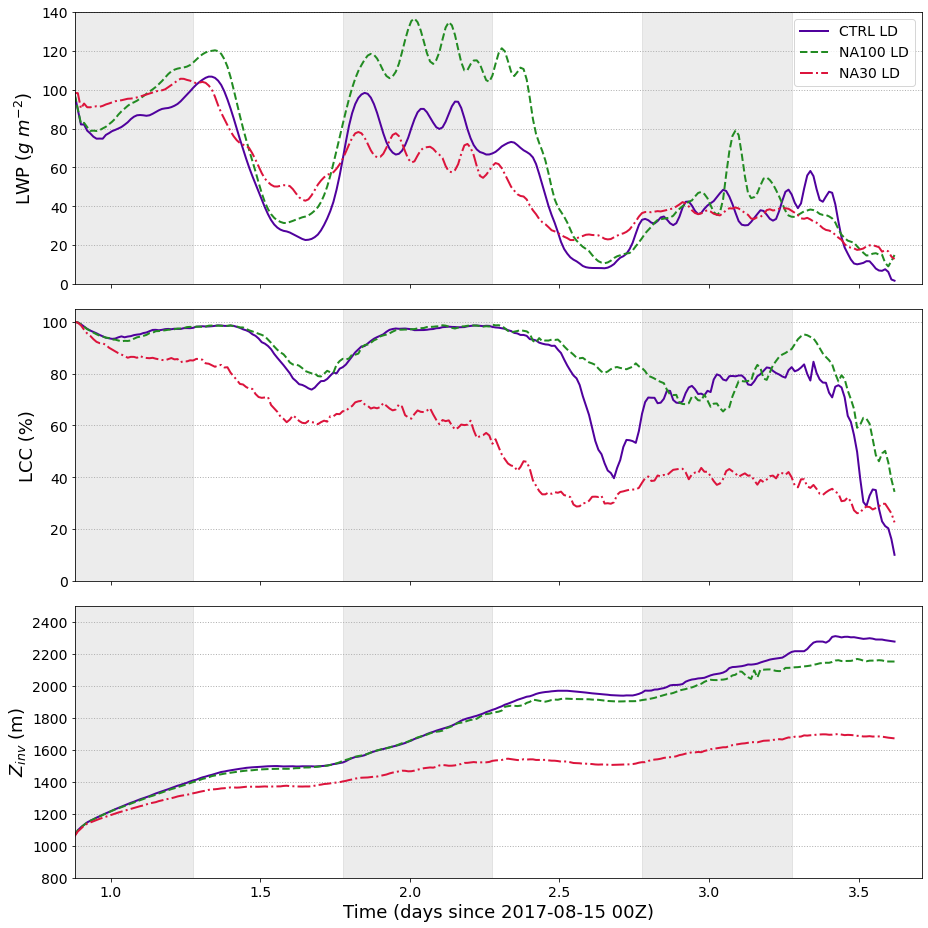

In [8]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 40
box = 5
####
fig, axis = plt.subplots(3, 1,figsize=(13,13))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('LWP ($g$ $m^{-2}$)', fontsize = '18')
axis[i].set_ylim([0, 140])
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('LCC (%)', fontsize = '18')
axis[i].set_ylim([0, 105])
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$Z_{inv}$ (m)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([800, 2500])
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

###
for jj in range(len(fn)):
    
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
    i = 0
    S_LWP = CWP + RWP
    try:
        axis[i].plot(time, np.concatenate([S_LWP[:10], smooth(S_LWP, box)[10:-5], S_LWP[-5:]]), ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    except:
        axis[i].plot(time, S_LWP[:10], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])        
    leg1 = axis[i].legend(fontsize = '14')#, loc='lower right')
    i = 1
    axis[i].plot(time, ISCCPTOT * 100, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj]) # CLDLOW will not be used.
    i = 2
    axis[i].plot(time, ZINV, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])

    
plt.tight_layout(w_pad=1)
plt.show()

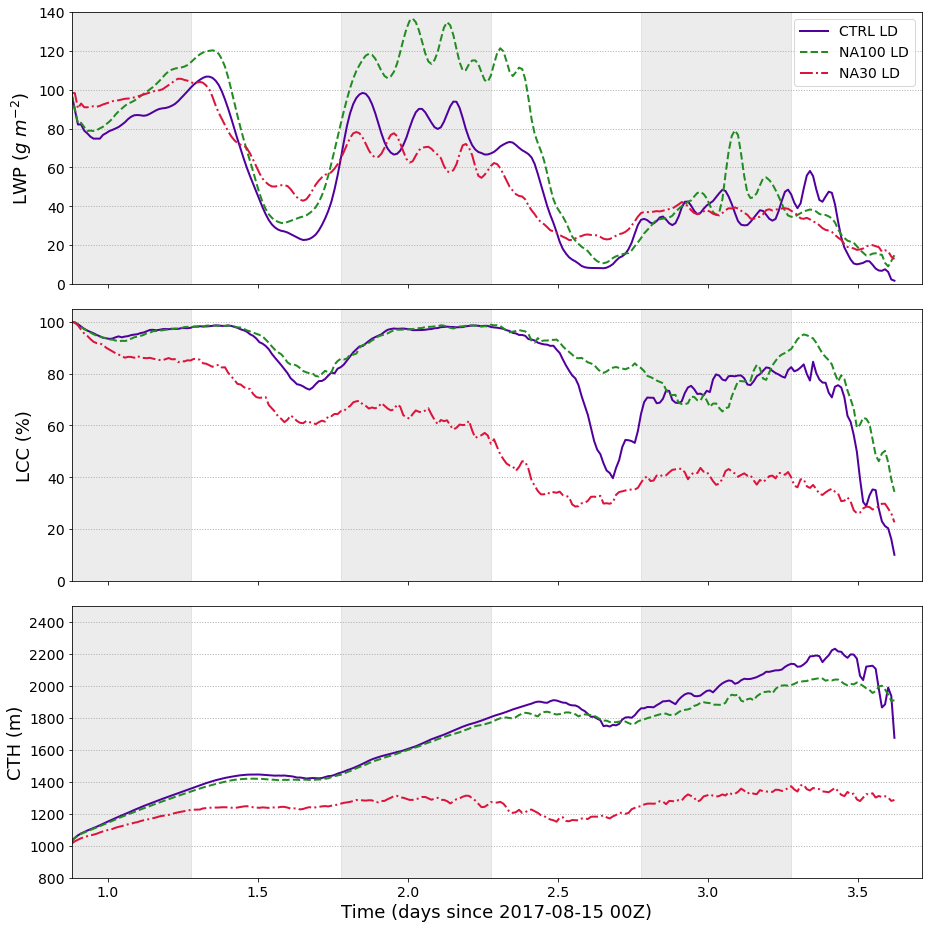

In [10]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 40
box = 5
####
fig, axis = plt.subplots(3, 1,figsize=(13,13))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('LWP ($g$ $m^{-2}$)', fontsize = '18')
axis[i].set_ylim([0, 140])
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('LCC (%)', fontsize = '18')
axis[i].set_ylim([0, 105])
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('CTH (m)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([800, 2500])
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

###
for jj in range(len(fn)):
    
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
    
    MISRZTOP   = fn[jj].variables['MISRZTOP'][:] * 1000     # MISR Cloud-Top Height (convert to m)
    
    i = 0
    S_LWP = CWP + RWP
    try:
        axis[i].plot(time, np.concatenate([S_LWP[:10], smooth(S_LWP, box)[10:-5], S_LWP[-5:]]), ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    except:
        axis[i].plot(time, S_LWP[:10], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])        
    leg1 = axis[i].legend(fontsize = '14')#, loc='lower right')
    i = 1
    axis[i].plot(time, ISCCPTOT * 100, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj]) # CLDLOW will not be used.
    i = 2
    axis[i].plot(time, MISRZTOP, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])

    
plt.tight_layout(w_pad=1)
plt.show()

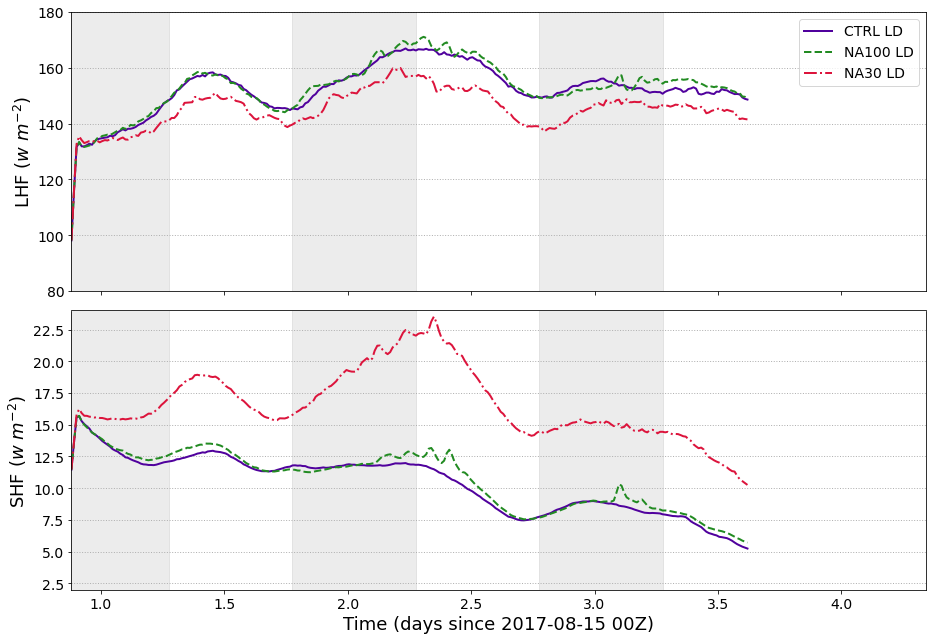

In [9]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 5
box = 10
ERA_c = 'orange'

####
fig, axis = plt.subplots(2, 1,figsize=(13,9))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('LHF ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([80, 180])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('SHF ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([2, 24])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


    ###
for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])

        i = 0
        axis[i].plot(time, LHF, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis[i].legend(fontsize = '14', loc='upper right')
        i = 1
        axis[i].plot(time, SHF, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])


plt.tight_layout(w_pad=1)
plt.show()


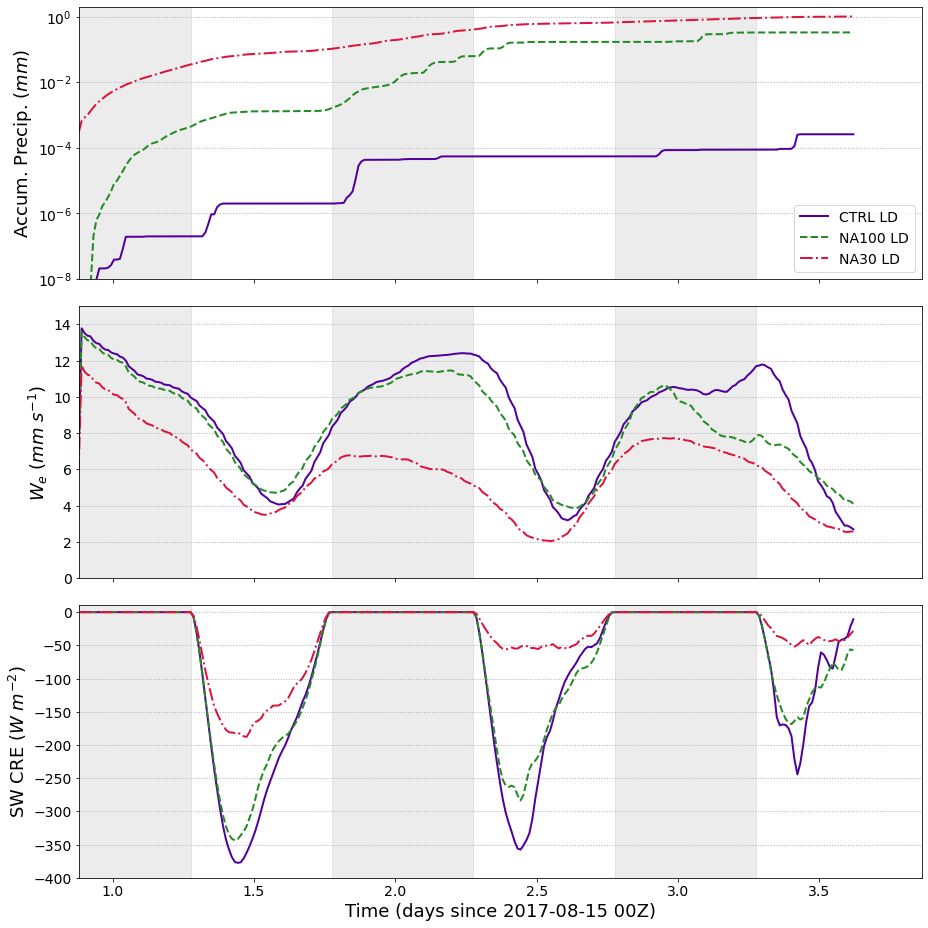

In [10]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 15
box = 10

upbound = time.copy()
upbound[:] = ylim
upbound[SWNS > 0] = np.nan

####
fig, axis = plt.subplots(3, 1,figsize=(13,13))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Accum. Precip. ($mm$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([1e-8, 2])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].set_yscale('log')

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$W_e$ ($mm$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 15])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('SW CRE ($W$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([-400, 10])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

###
for jj in range(len(fn)):
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
    
    i = 0
    axis[i].plot(time, acc_prec, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    axis[i].legend(fontsize = '14', loc='lower right')
    i = 1
    axis[i].plot(time, entr, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    i = 2
    axis[i].plot(time, SW_CRE, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj]) # CLDLOW will not be used.


plt.tight_layout(w_pad=1)
plt.show()

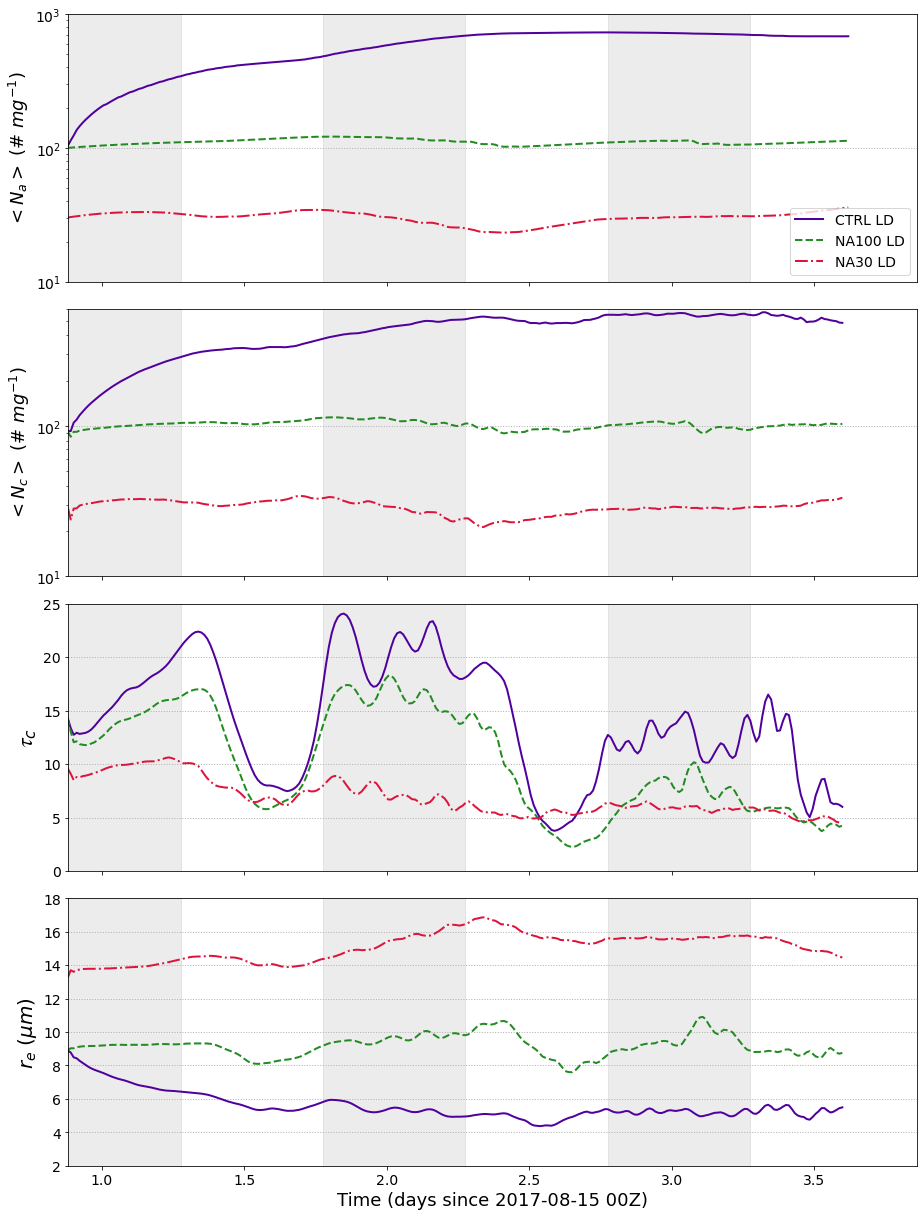

In [11]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 15
box = 5

upbound = time.copy()
upbound[:] = ylim
upbound[SWNS > 0] = np.nan


#####
fig, axis = plt.subplots(4, 1,figsize=(13,17))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$<N_a>$ (# $mg^{-1}$)', fontsize = '18')
axis[i].set_ylim([1e1, 1e3])
axis[i].set_xlim([start, xlim + xlim/lngh])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].set_yscale('log')

####
i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$<N_c>$ (# $mg^{-1}$)', fontsize = '18')
axis[i].set_ylim([1e1, 6e2])
axis[i].set_xlim([start, xlim + xlim/lngh])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].set_yscale('log')

####
i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$𝜏_c$', fontsize = '22')
axis[i].set_ylim([0, 25])
axis[i].set_xlim([start, xlim + xlim/lngh])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

######
i = 3
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('$r_e$ ($μm$)', fontsize = '20')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_ylim([2, 18])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].set_xlim([start, xlim + xlim/lngh])
axis[i].grid(linestyle=':', axis='y', linewidth=1)

###########
for jj in range(len(fn)):
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])

    i = 0
    axis[i].plot(time, integ_NA_BL, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    leg1 = axis[i].legend(fontsize = '14', loc='lower right')

    i = 1
    try:
        axis[i].plot(time[:-2], np.concatenate( [integ_NC_BL[:3], smooth(integ_NC_BL, box)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    except:
        axis[i].plot(time, integ_NC_BL, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])        
 
    i = 2
    COD_fin = COD / ISCCPTOT
    try:
        axis[i].plot(time[:-2], np.concatenate( [COD_fin[:3], smooth(COD_fin, box)[3:] ] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    except:
        axis[i].plot(time, COD_fin, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])                
    
    i = 3
    try:
        axis[i].plot(time[:-2], np.concatenate( [SAM_re[:3], smooth(SAM_re, box)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
    except:
        axis[i].plot(time, SAM_re, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])                        

plt.tight_layout(w_pad=1)
plt.show()

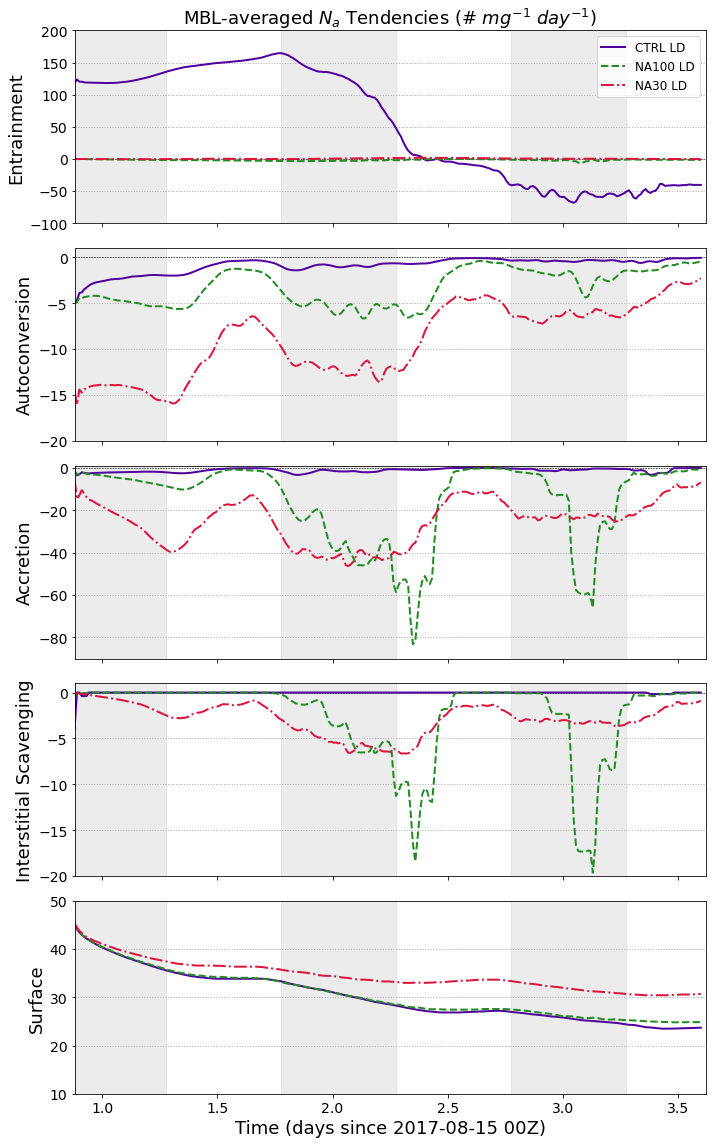

In [12]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

zero = time.copy()
zero[:] = 0
box = 5
#####
fig, axis = plt.subplots(5, 1, figsize=(10,16))
for i in range(5):
    if i == 4:
        axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    else:
        axis[i].axes.get_xaxis().set_ticklabels([])
    if i == 0:
        axis[i].set_title('MBL-averaged $N_a$ Tendencies (# $mg^{-1}$ $day^{-1}$)', fontsize = '18')

    upbound = time.copy()
    upbound[:] = ylim
    upbound[SWNS > 0] = np.nan
    zero = time.copy()
    zero[:] = 0

    axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
    axis[i].plot(time, zero, '--', c='k', linewidth=.5)       
    axis[i].set_xlim([start, xlim])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)
    axis[i].set_ylim([None, None])
    
    for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
        acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
        height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
        LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
        if i==0:
            try:
                axis[i].plot(time[:-2], np.concatenate( [height_ENTRNMT[:3], smooth(height_ENTRNMT, box)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
            except:
                axis[i].plot(time, height_ENTRNMT, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])                
            axis[i].set_ylabel('Entrainment', fontsize = '18')
            axis[i].set_ylim([-100, 200])
        if i ==1:            
            try:
                axis[i].plot(time[:-2], np.concatenate( [height_NARC[:3], smooth(height_NARC, box)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
            except:
                axis[i].plot(time, height_NARC, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])                
            axis[i].set_ylabel('Autoconversion', fontsize = '18')
            axis[i].set_ylim([-20, 1])
        if i ==2:            
            try:
                axis[i].plot(time[:-2], np.concatenate( [height_NPRA[:3], smooth(height_NPRA, box*2)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
            except:
                axis[i].plot(time, height_NPRA, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])                
            axis[i].set_ylabel('Accretion', fontsize = '18')
            axis[i].set_ylim([-90, 1])
        if i ==3:            
            try:
                axis[i].plot(time[:-2], np.concatenate( [height_NASCAV[:3], smooth(height_NASCAV, box*2)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
            except:
                axis[i].plot(time, height_NASCAV, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])                
            axis[i].set_ylabel('Interstitial Scavenging', fontsize = '18')
            axis[i].set_ylim([-20, 1])
        if i ==4:
            try:
                axis[i].plot(time[:-2], np.concatenate( [height_NASURF[:3], smooth(height_NASURF, box)[3:]] )[:-2], ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
            except:
                axis[i].plot(time, height_NASURF, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])                
            axis[i].set_ylabel('Surface', fontsize = '18')
            axis[i].set_ylim([10, 50])
axis[0].legend(fontsize = '12', loc='upper right')
plt.tight_layout(w_pad=1)
plt.show()

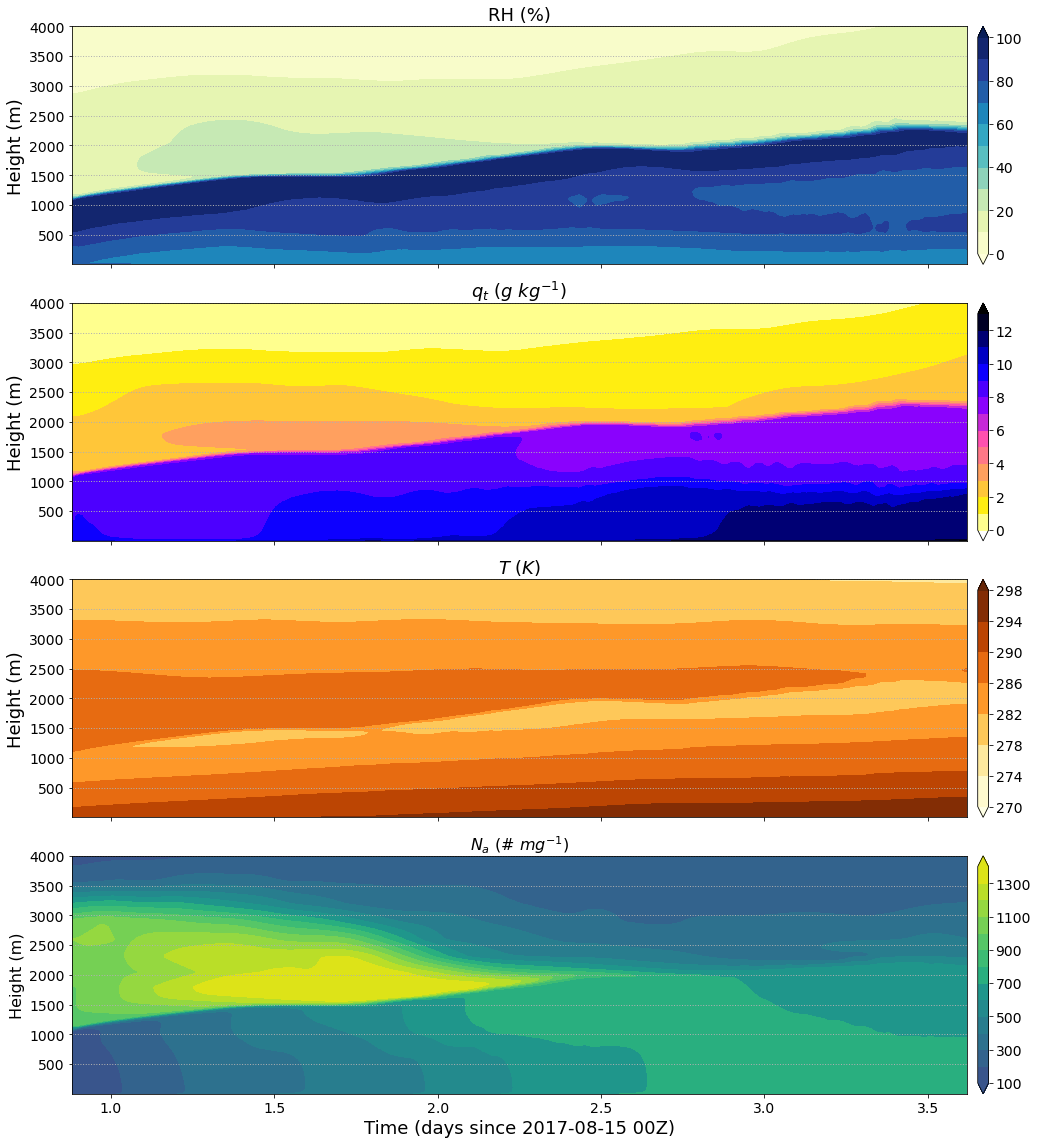

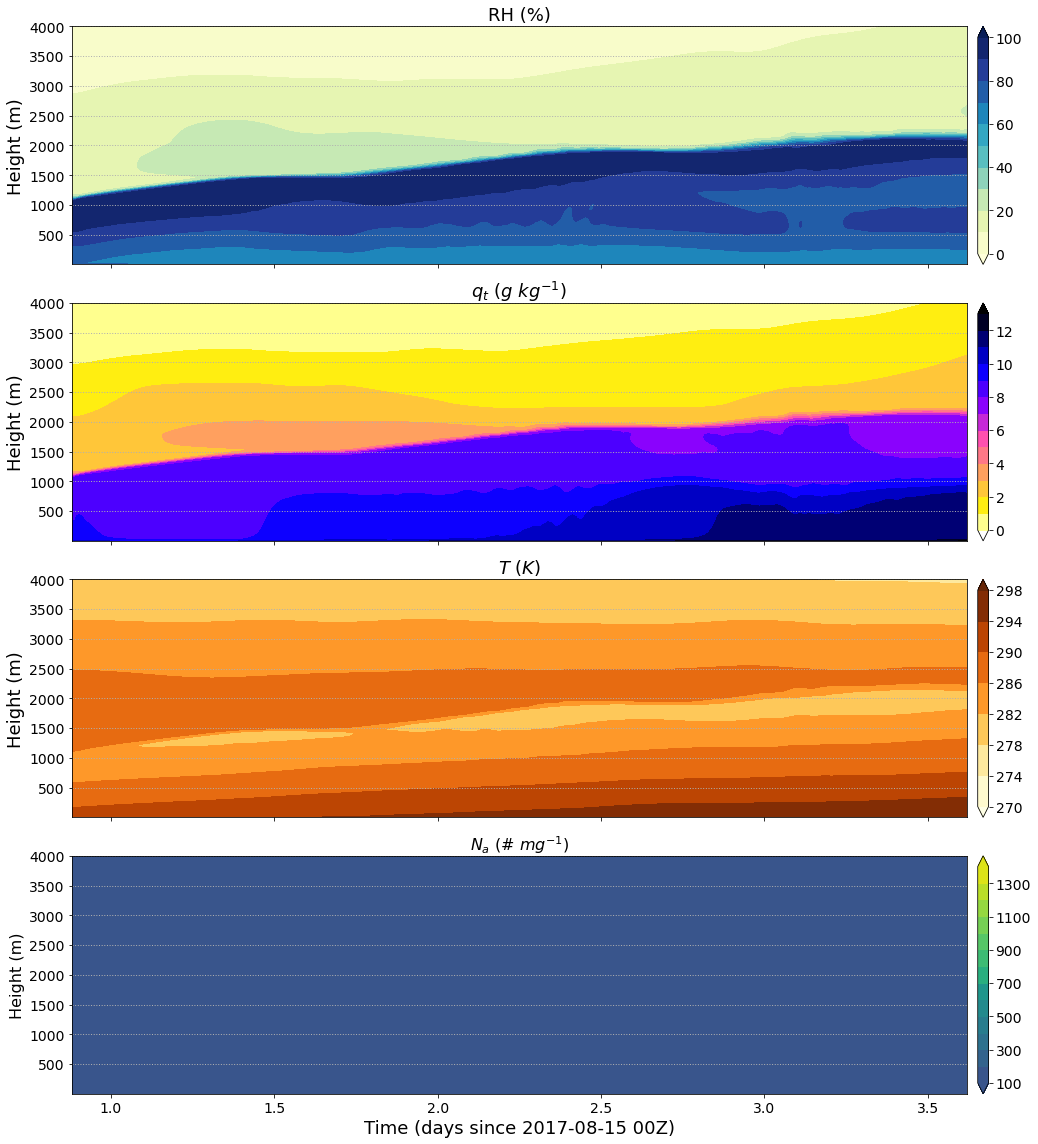

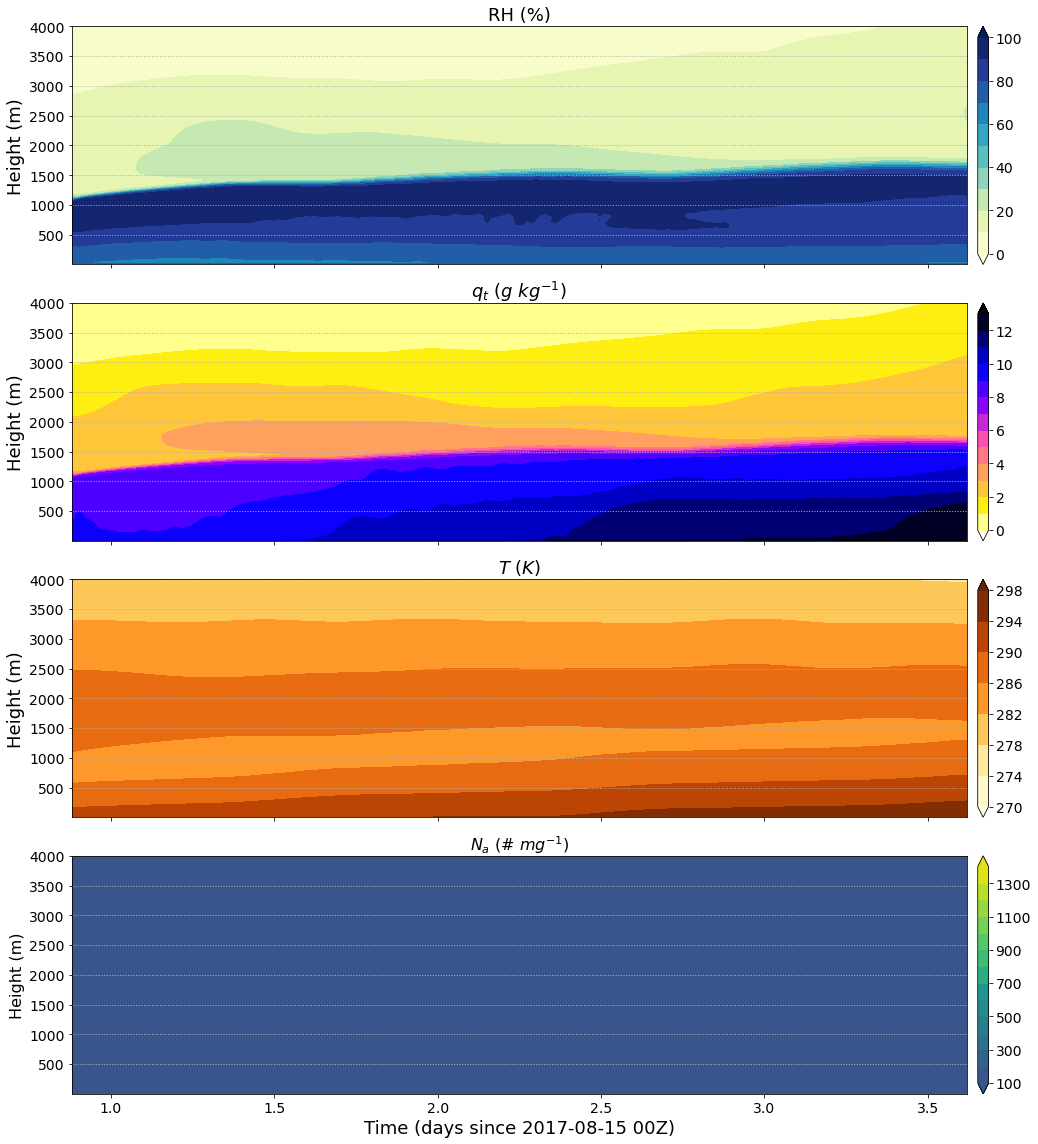

In [14]:
time, z, dz, RHO, CWP, RWP, ISccPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

lngh = 15
box = 5


cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])


#######
for jj in range(len(fn)):
    
    
    
    fig, axis = plt.subplots(4, 1,figsize=(16,16))

    i = 0
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('RH (%)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([start, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)


    i = 1
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([start, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 2
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('$T$ ($K$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([start, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)


    i = 3
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([start, ylim])    
    axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    time, z, dz, RHO, CWP, RWP, ISccPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])

    z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

    i = 0
    clevs = np.arange(0, 101, 10)
    clevs2 = np.arange(0, 101, 10)
    cc1 = axis[i].contourf(time_mg, z_mg, RH, clevs, extend='both', cmap = 'YlGnBu')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 1
    clevs = np.arange(0, 14, 1)
    ticks = np.arange(0, 14, 2)
    cc1 = axis[i].contourf(time_mg, z_mg, QT, clevs, extend='both', cmap = 'gnuplot2_r')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 2
    clevs = np.arange(270, 300.01, 4)
    ticks = np.arange(270, 300.01, 4)
    cc1 = axis[i].contourf(time_mg, z_mg, TABS, clevs, extend='both', cmap = 'YlOrBr')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 3
    clevs = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
    ticks = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
    clevs = [10, 30, 60, 100, 300, 600, 1000]
    ticks = [10, 30, 60, 100, 300, 600, 1000]
    clevs = np.arange(100, 1500, 100)
    cc1 = axis[i].contourf(time_mg, z_mg, NA, clevs, extend='both', cmap = cmap)#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)


    plt.tight_layout(w_pad=1)
    plt.show()

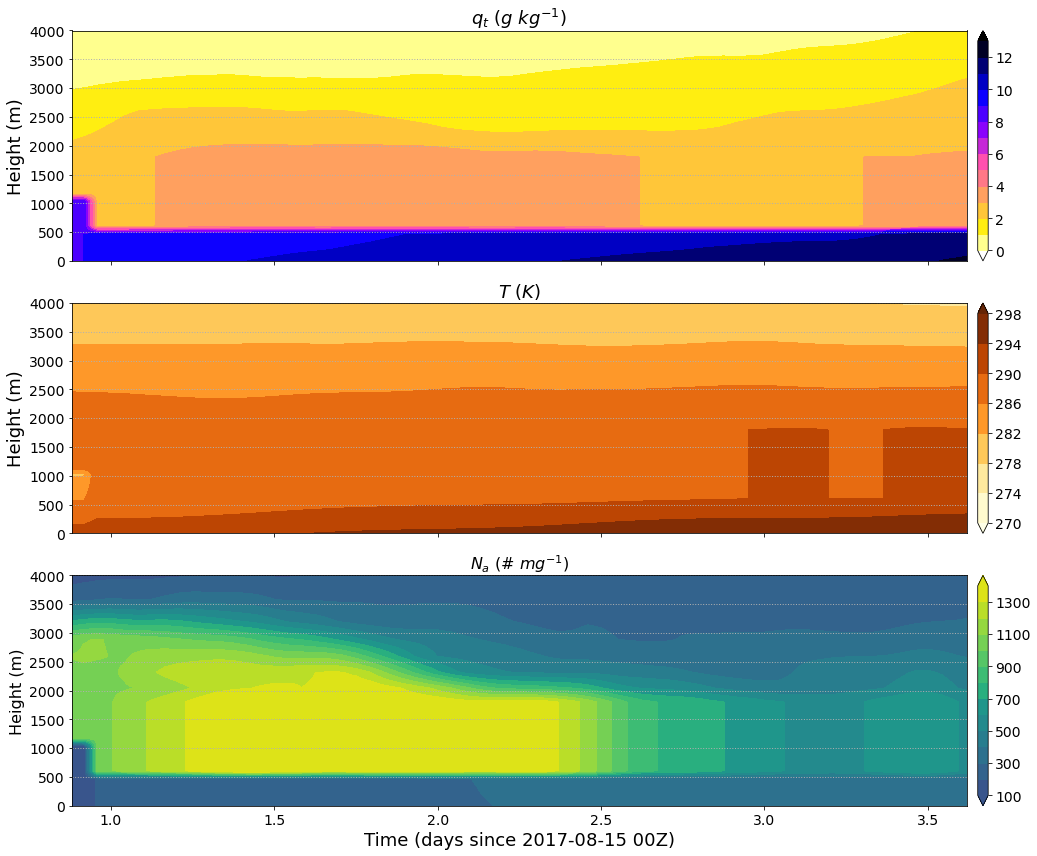

In [15]:
lngh = 15
box = 5


cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

fig, axis = plt.subplots(3, 1,figsize=(16,12))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$T$ ($K$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


i = 2
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(0, 14, 1)
ticks = np.arange(0, 14, 2)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], qt_fo[:,:,0,0], clevs, extend='both', cmap = 'gnuplot2_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(270, 300.01, 4)
ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Tref[:,:,0,0], clevs, extend='both', cmap = 'YlOrBr')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
ticks = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
clevs = [10, 30, 60, 100, 300, 600, 1000]
ticks = [10, 30, 60, 100, 300, 600, 1000]
clevs = np.arange(100, 1500, 100)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Na_accm[:,:,0,0], clevs, extend='both', cmap = cmap)#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

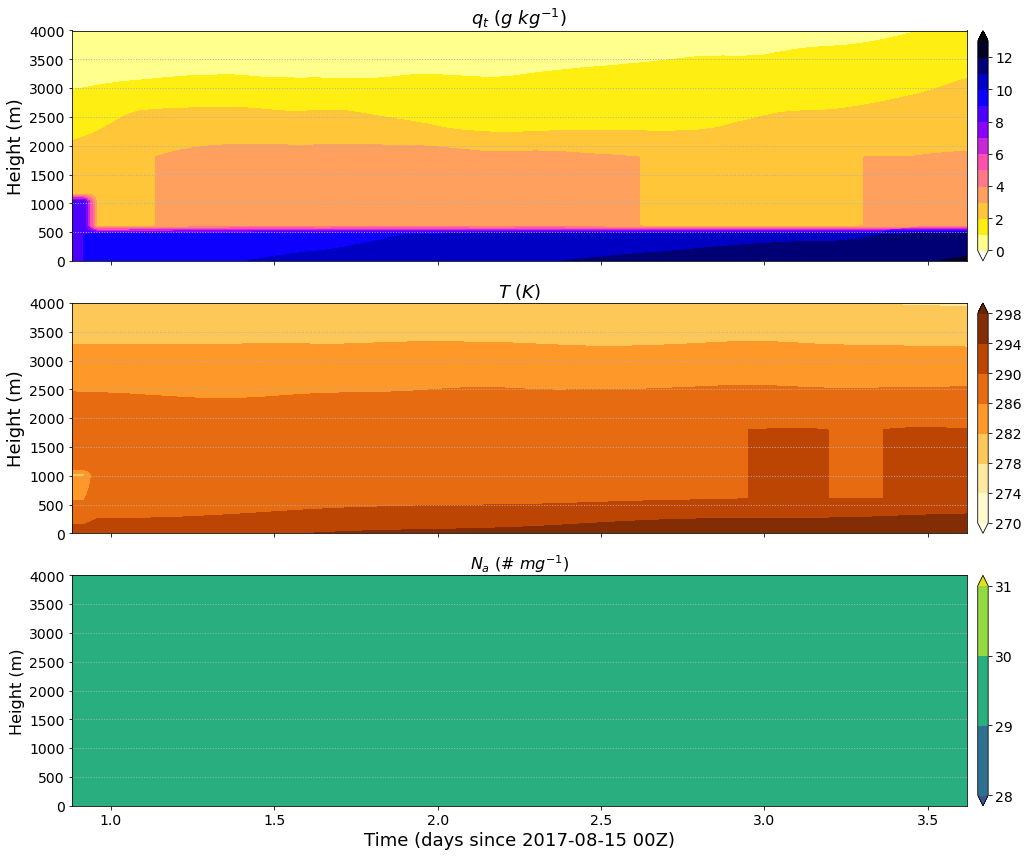

In [16]:
forcing = Dataset('../SEA_STARR_FAST/SEA_STARR_N30_SCM_driver_SCAMIOP_Created_05-Aug-2022.nc')

## variables in the forcing file:
day    = forcing.variables['day'][:] 
calday = forcing.variables['calday'][:] 
lat    = forcing.variables['lat'][:]             # Surface Latent Heat Flux:
qref   = forcing.variables['qref'][:] * 1000      # Water Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
qt_fo  = forcing.variables['q'][:] * 1000         # Total Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
Tref   = forcing.variables['Tref'][:]             # Absolute Temperature          from from ERA-5: K
SST_fo = forcing.variables['Tg'][:]               # Surface Temperature (SST if over water): K
u_fo   = forcing.variables['u'][:]                # Zonal Wind: m/s
v_fo   = forcing.variables['v'][:]                # Meridional Wind: m/s
ug_fo  = forcing.variables['ug'][:]               # Geostrophic Zonal Wind: m/s
vg_fo  = forcing.variables['vg'][:]               # Geostrophic Meridional Wind: m/s
z_forc = forcing.variables['z'][:]               # Geopotential height from ERA-5:
Na_accm= forcing.variables['Na_accum'][:] / 1e6  # Accumulation mode aerosol number mixing ratio from MERRA2 (Corrected based on regression w/in situ CSET data)
omega  = forcing.variables['omega'][:]           # Vertical Pressure Velocity: Pa/s
fday   = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z_forc[0,:,0,0], fday) # making meshgrid

#####

lngh = 15
box = 5


cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

fig, axis = plt.subplots(3, 1,figsize=(16,12))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$T$ ($K$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


i = 2
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(0, 14, 1)
ticks = np.arange(0, 14, 2)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], qt_fo[:,:,0,0], clevs, extend='both', cmap = 'gnuplot2_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(270, 300.01, 4)
ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Tref[:,:,0,0], clevs, extend='both', cmap = 'YlOrBr')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
ticks = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
clevs = [10, 30, 60, 100, 300, 600, 1000]
ticks = [10, 30, 60, 100, 300, 600, 1000]
clevs = np.arange(28, 32, 1)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Na_accm[:,:,0,0], clevs, extend='both', cmap = cmap)#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

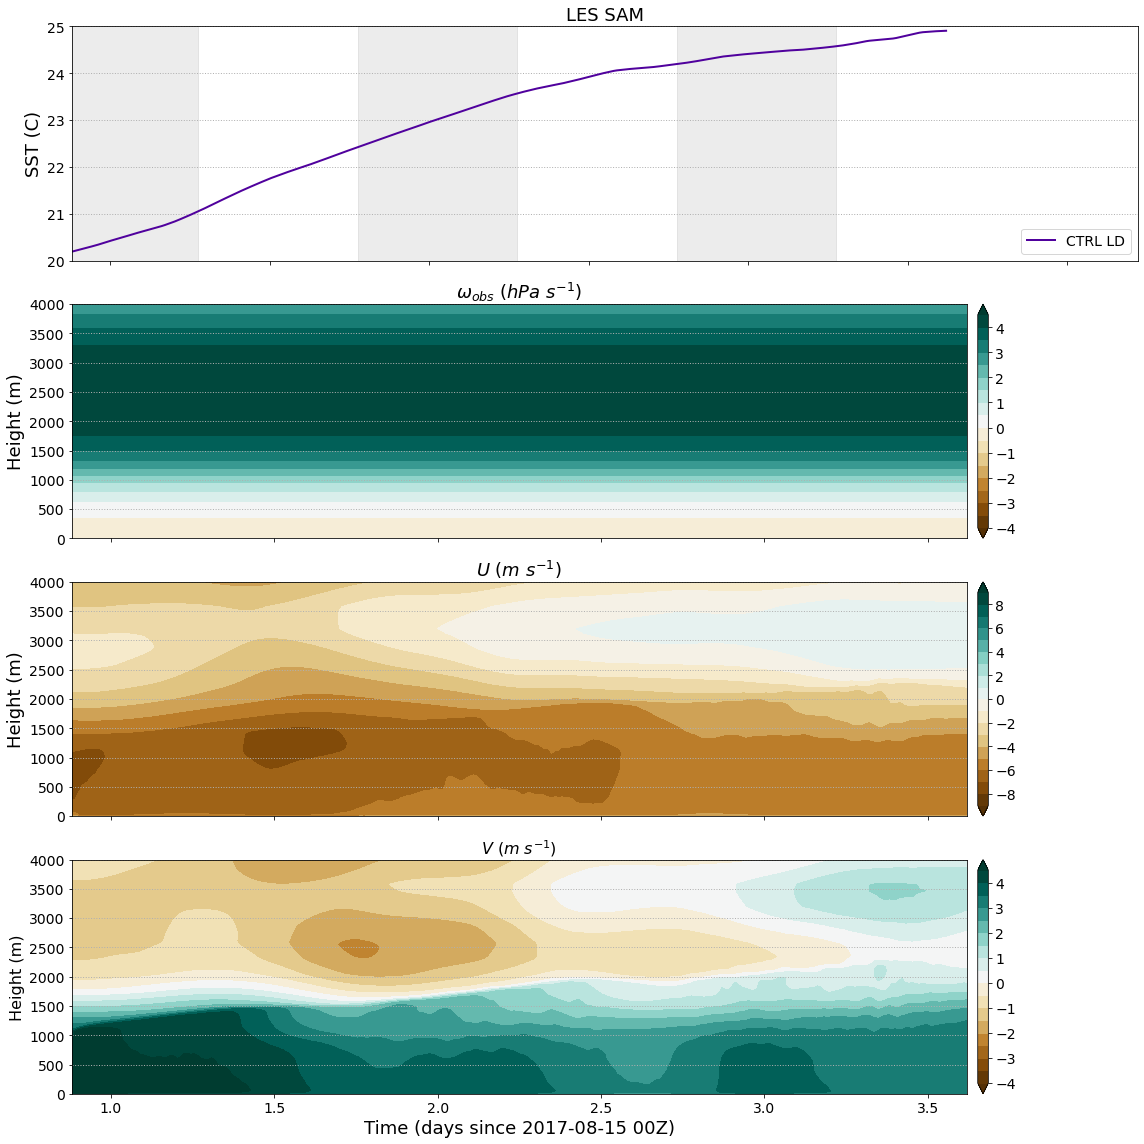

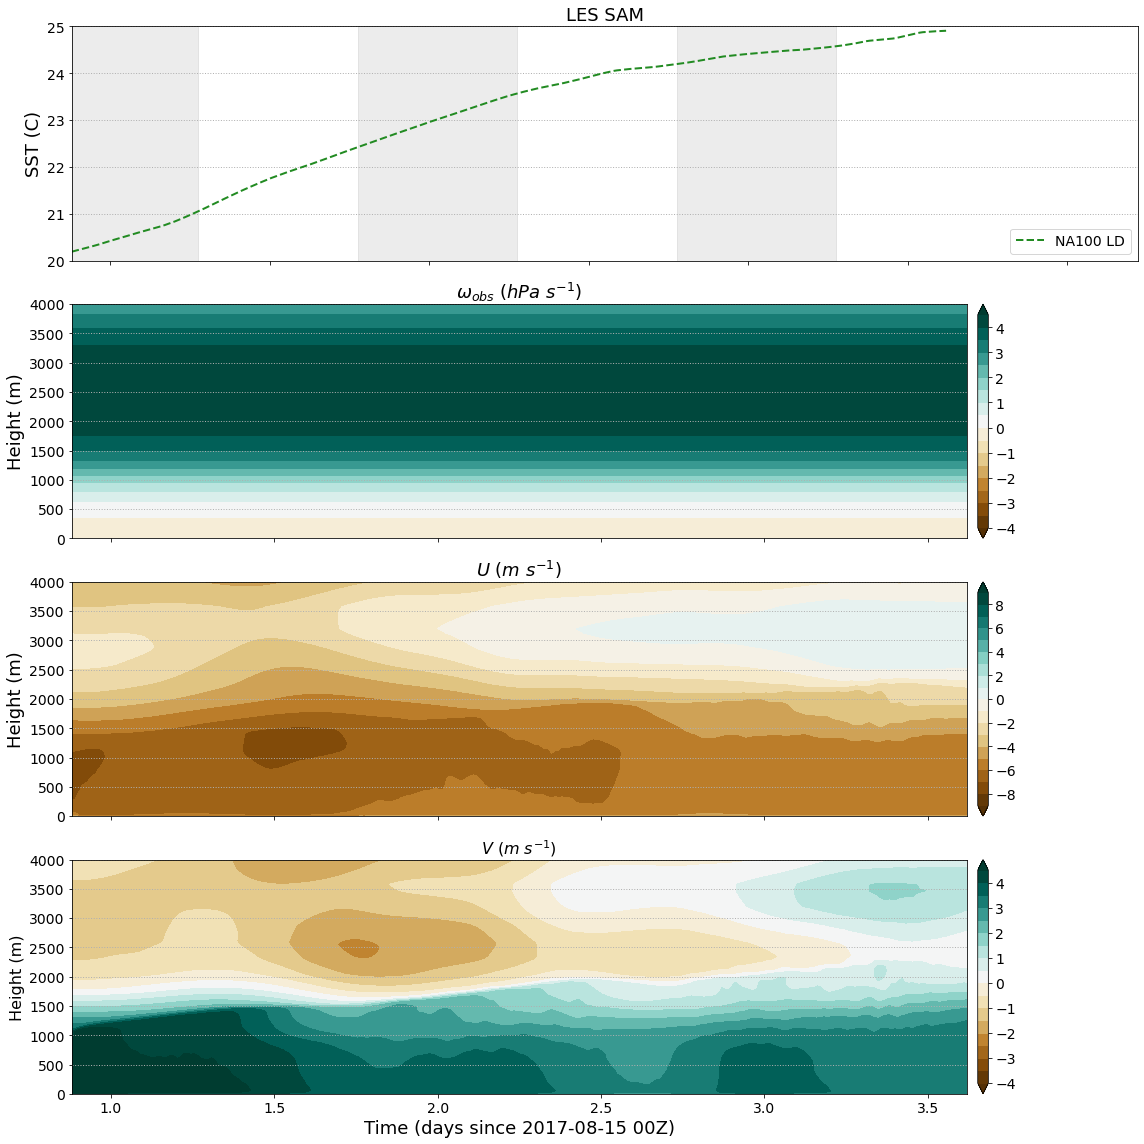

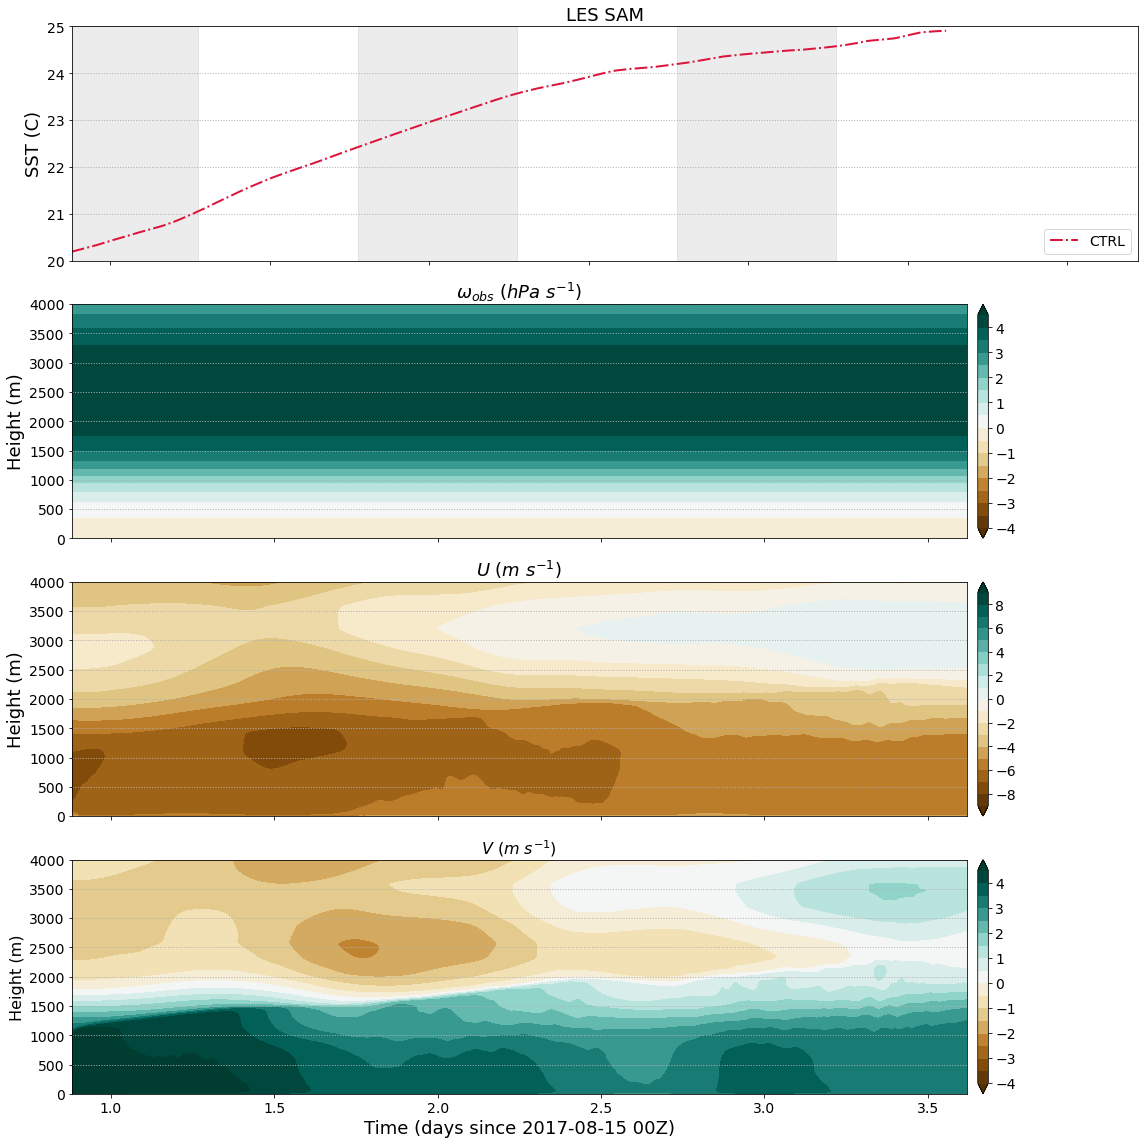

In [17]:
for jj in range(len(fn)):
    
    time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
                acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
                height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
                LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

    z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

    lngh = 15
    box = 5


    cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
    cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

    ##########
    fig, axis = plt.subplots(4, 1,figsize=(16,16))

    i = 0
    axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
    axis[i].set_ylabel('SST (C)', fontsize = '18')
    axis[i].set_title('LES SAM', fontsize = '18')
    axis[i].set_xlim([start, xlim + 0.6])
    axis[i].set_ylim([20, 25])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 1
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('$\omega_{obs}$ ($hPa$ $s^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 2
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('$U$ ($m$ $s^{-1}$)', fontsize = '18')
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 3
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('$V$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([start, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)
    z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

    i = 0
    cc1 = axis[i].plot(time, SST, ls[jj], color=cc[jj], linewidth= lw[jj], label=lb[jj])
    leg1 = axis[i].legend(fontsize = '14', loc='lower right')

    i = 1
    clevs = np.arange(-5, 6, 0.5)
    clevs = np.arange(-4, 5, 0.5)
    cc1 = axis[i].contourf(time_mg, z_mg, - WOBS * RHO * 9.81 * 100, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 2
    clevs = np.arange(-9, 10, 1)
    cc1 = axis[i].contourf(time_mg, z_mg, U, clevs, extend='both', cmap = 'BrBG')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 3
    clevs = np.arange(-4, 5, 0.5)
    cc1 = axis[i].contourf(time_mg, z_mg, V, clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)


    plt.tight_layout(w_pad=1)
    plt.show()

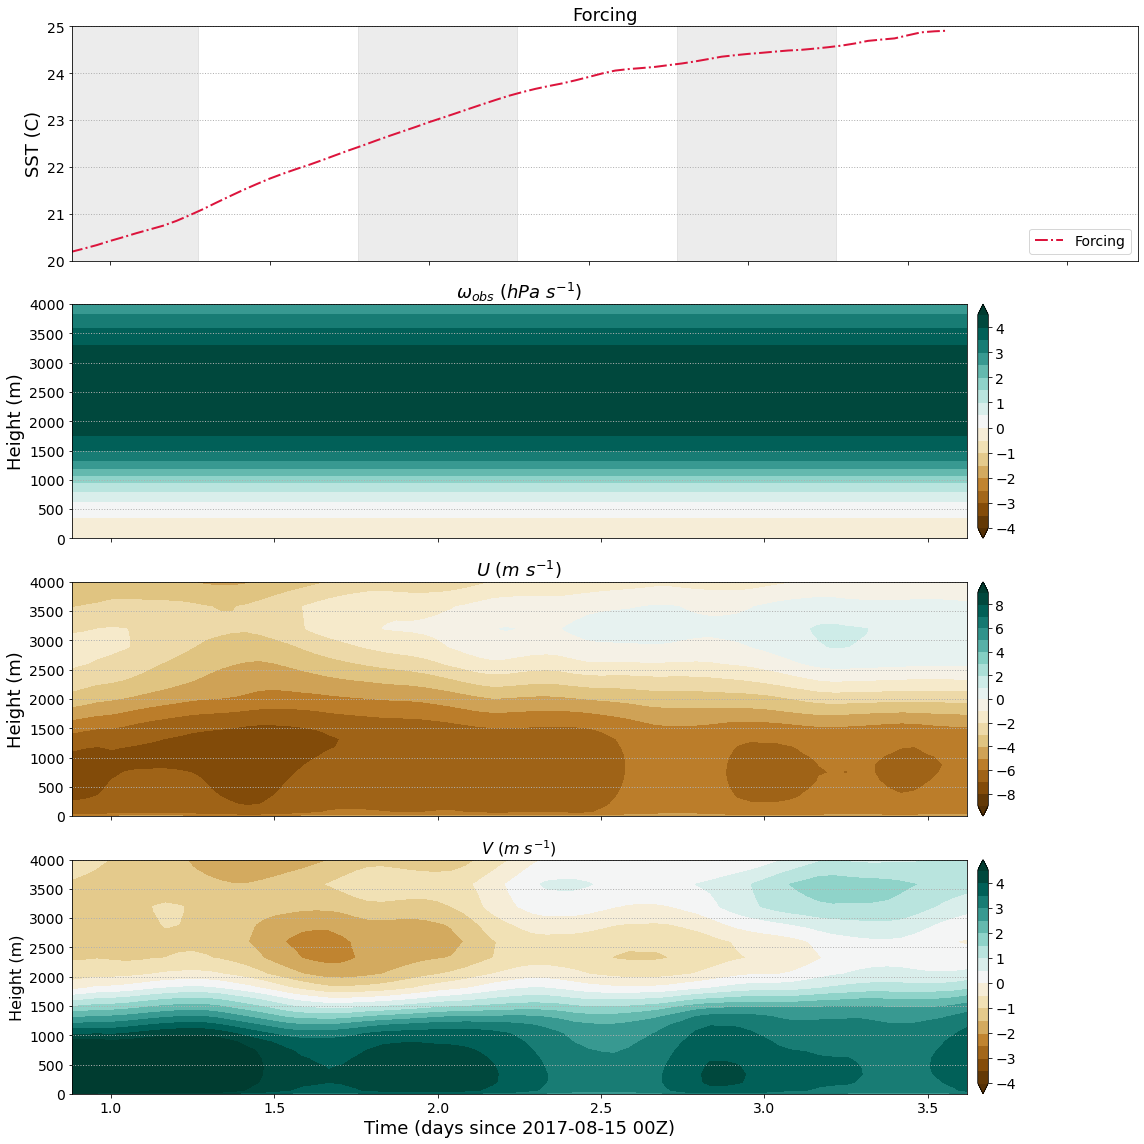

In [18]:
lngh = 15
box = 5


fig, axis = plt.subplots(4, 1,figsize=(16,16))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('SST (C)', fontsize = '18')
axis[i].set_title('Forcing', fontsize = '18')
axis[i].set_xlim([start, xlim + 0.6])
axis[i].set_ylim([20, 25])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$\omega_{obs}$ ($hPa$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$U$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 3
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$V$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
cc1 = axis[i].plot(fday, SST_fo[:,0,0] - 273.15, ls[jj], color=cc[jj], linewidth= lw[jj], label='Forcing')
leg1 = axis[i].legend(fontsize = '14', loc='lower right')

i = 1
clevs = np.arange(-5, 6, 0.5)
clevs = np.arange(-4, 5, 0.5)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], omega[:,:,0,0] * 100, clevs, extend='both', cmap = 'BrBG')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = np.arange(-9, 10, 1)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], u_fo[:,:,0,0], clevs, extend='both', cmap = 'BrBG')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 3
clevs = np.arange(-4, 5, 0.5)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], v_fo[:,:,0,0], clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

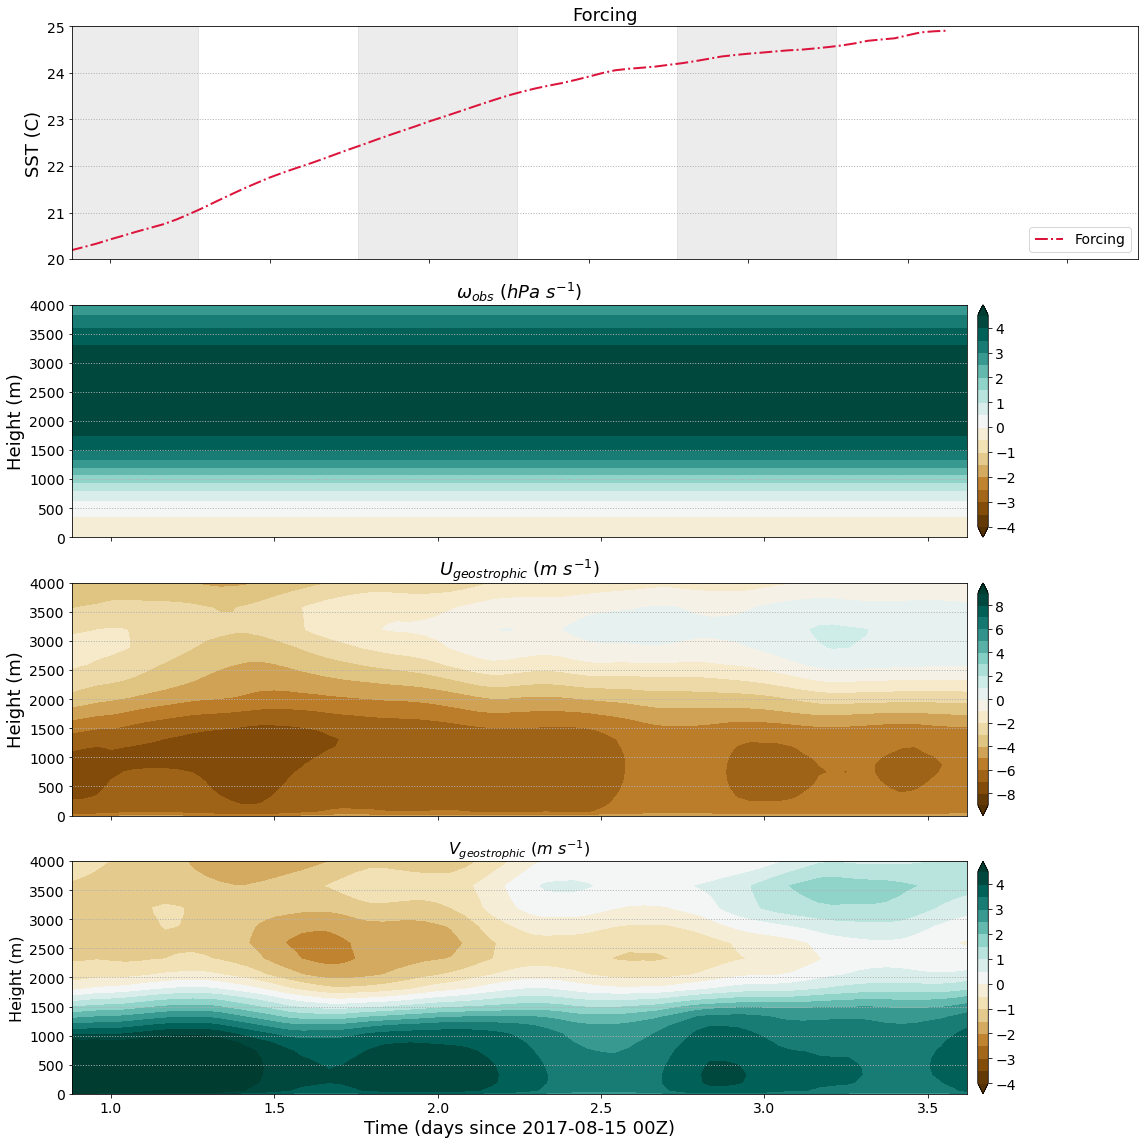

In [19]:
lngh = 15
box = 5


fig, axis = plt.subplots(4, 1,figsize=(16,16))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('SST (C)', fontsize = '18')
axis[i].set_title('Forcing', fontsize = '18')
axis[i].set_xlim([start, xlim + 0.6])
axis[i].set_ylim([20, 25])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$\omega_{obs}$ ($hPa$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$U_{geostrophic}$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 3
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$V_{geostrophic}$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
cc1 = axis[i].plot(fday, SST_fo[:,0,0] - 273.15, ls[jj], color=cc[jj], linewidth= lw[jj], label='Forcing')
leg1 = axis[i].legend(fontsize = '14', loc='lower right')

i = 1
clevs = np.arange(-5, 6, 0.5)
clevs = np.arange(-4, 5, 0.5)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], omega[:,:,0,0] * 100, clevs, extend='both', cmap = 'BrBG')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = np.arange(-9, 10, 1)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], ug_fo[:,:,0,0], clevs, extend='both', cmap = 'BrBG')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 3
clevs = np.arange(-4, 5, 0.5)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], vg_fo[:,:,0,0], clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

In [20]:
fday_mg, z_forc[:,:,0,0], qt_fo[:,:,0,0]
w_mic
SST_fo
u_fo[:,:,0,0]

masked_array(
  data=[[11.115925 , 16.408506 , 16.166395 , ..., -6.0432096, -5.794841 ,
         -5.2606845],
        [11.115925 , 16.408506 , 16.166395 , ..., -6.031934 , -5.784029 ,
         -5.2508693],
        [11.115925 , 16.408506 , 16.166395 , ..., -5.964635 , -5.719496 ,
         -5.1922846],
        ...,
        [11.115925 , 16.408506 , 16.166395 , ..., -5.0052605, -4.7995505,
         -4.3571377],
        [11.115925 , 16.408506 , 16.166395 , ..., -4.9550443, -4.7513976,
         -4.313424 ],
        [11.115925 , 16.408506 , 16.166395 , ..., -4.924134 , -4.721758 ,
         -4.286516 ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

## Aerosol Absorption

IndexError: list index out of range

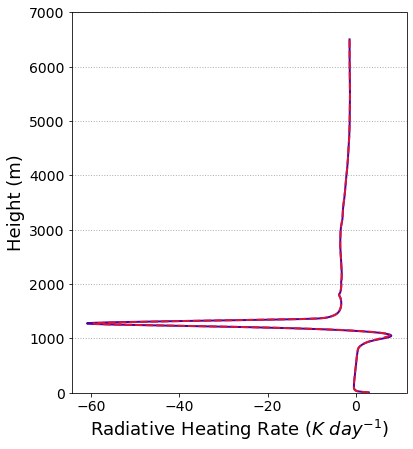

In [21]:
# Thanks for these. Following up on Rob’s questions during the meeting today, it would be helpful 
# to compare the two runs using profiles of RADQR, NAC, NCCLD, QT, QCL, TL (sli/cp) and THETAV from 3-6am 
# local time during each day of the simulation. This might help us understand why the LWP is so different 
# on the first night but is broadly similar between the two runs after that time.

test_vars = ['RADQR', 'NAc', 'NCCLD', 'QT', 'QCL', 'TL', 'THETAV']
test_vars_name = ['Radiative Heating Rate ($K$ $day^{-1}$)', 'Number Concentration ($mg^{-1}$)',
                 'Cloud Number Concentration ($mg^{-1}$)', 'Total Water ($g$ $kg^{-1}$)', 
                 'Cloud Water ($g$ $kg^{-1}$)', 'Liquid Water Static Energy ($K$)', 'Virtual Potential Temperature ($K$)']

lstl = ['-', '--']

########
for ddd in [1, 2, 3]:
    for ii in range(len(test_vars)):

        fig, axis = plt.subplots(1, 1,figsize=(6,7))

        i = 0
        axis.set_ylabel('Height (m)', fontsize = '18')
        axis.set_xlabel(test_vars_name[ii], fontsize = '18')
    #    if ii == 1:
    #        axis.set_xlim([0, 5])
    #    elif ii == 3:
    #        axis.set_xlim([-10, 5])
        axis.set_ylim([0, 7000])
        axis.tick_params(axis='both', which='major', labelsize=14)
        axis.grid(linestyle=':', axis='y', linewidth=1)


        for jj in range(len(fn)):
#             time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
#                 acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
#                 height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
#                 LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
            var_a = fn[jj].variables[test_vars[ii]][:]
            TIME  = fn[jj].variables['time'][:]
            time  = TIME - int(TIME[0])
            z     = fn[jj].variables['z'][:]

            ## find 3-6am local time (which is roughly 2-5 UTC)
            h1  = 2
            h2  = 5
            hours = time * 24 - ddd * 24
            id_t1 = np.where( abs(hours - h1) == np.nanmin( abs(hours - h1) ) )[0][0]
            id_t2 = np.where( abs(hours - h2) == np.nanmin( abs(hours - h2) ) )[0][0]

            var_a_m = np.nanmean(var_a[id_t1:id_t2+1], 0)
            
            axis.plot(var_a_m, z, lstl[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis.legend(fontsize = '14')#, bbox_to_anchor=(1, 0.5))#, loc='upper right')
        TITLE = 'Day ' + str(ddd) + ', 3-6 AM local time'
        axis.set_title(TITLE, fontsize=18 )
        plt.savefig(test_vars[ii] + ' ' + TITLE + '.png' , format='png', dpi=200)
        plt.tight_layout(w_pad=1)
        plt.show()

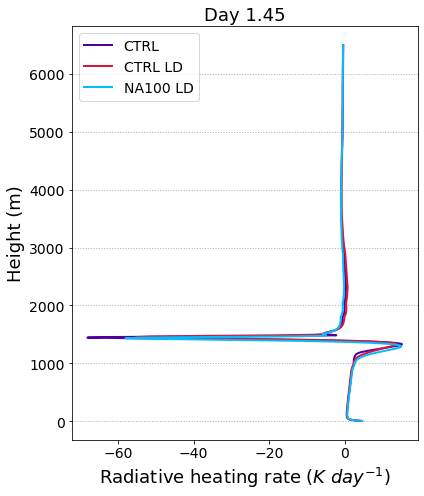

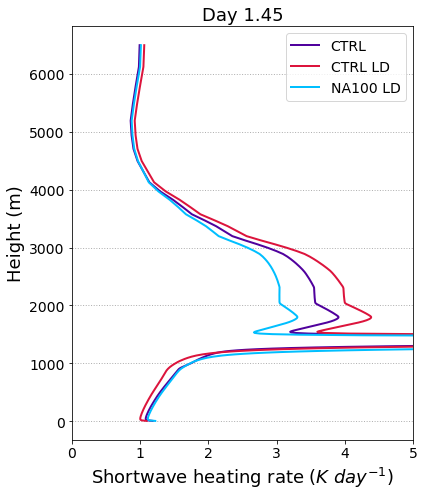

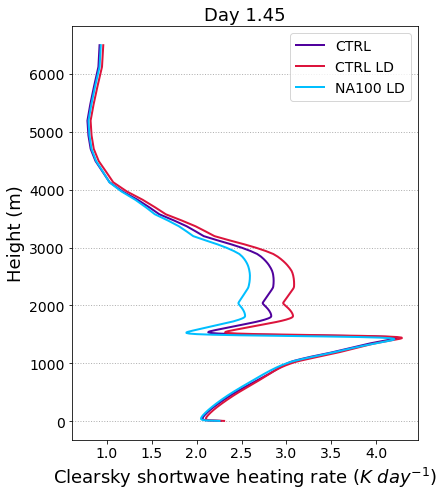

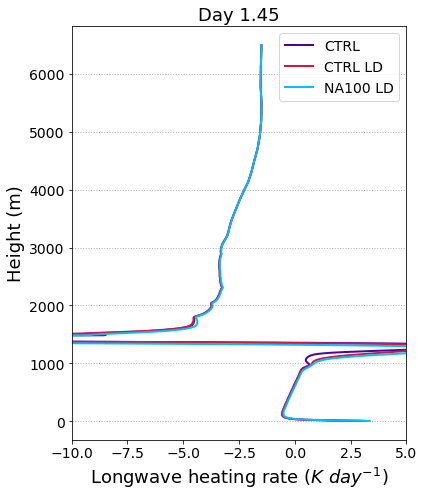

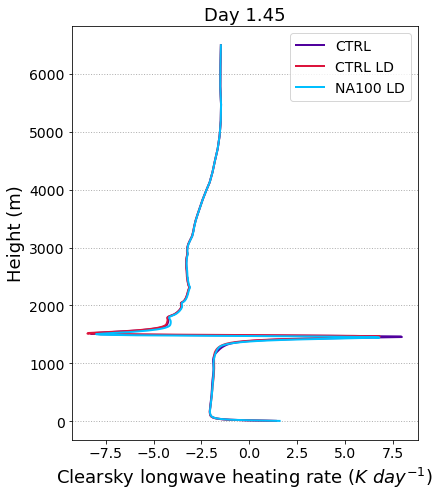

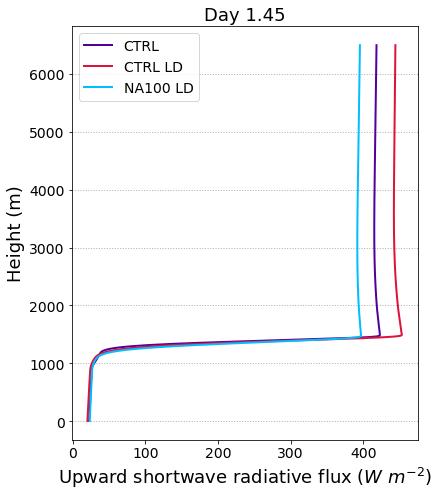

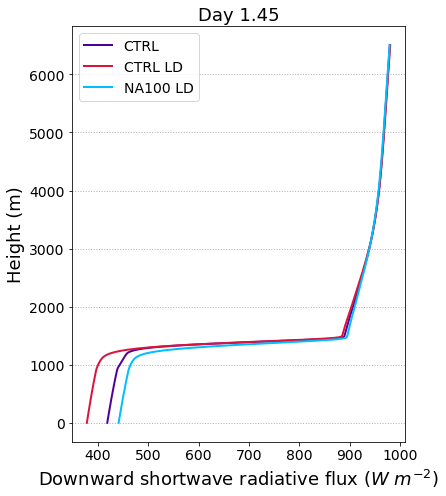

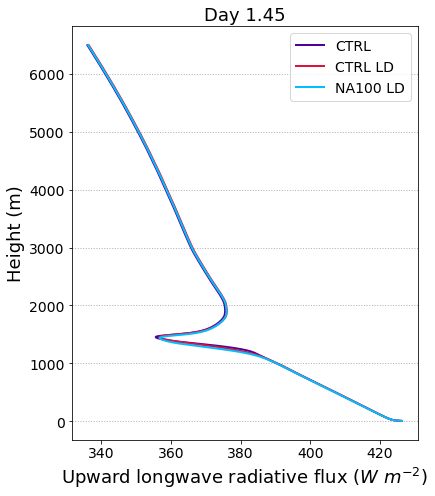

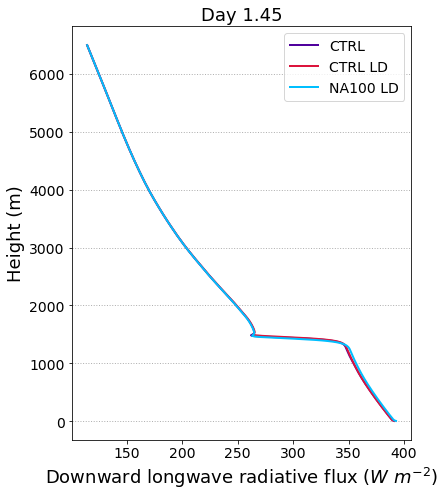

IndexError: index 0 is out of bounds for axis 0 with size 0

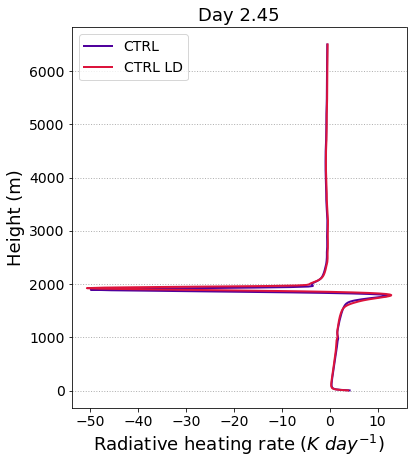

In [14]:
rad_vars = ['RADQR', 'RADQRSW', 'RADQRCSW', 'RADQRLW', 'RADQRCLW', 
            'RADSWUP', 'RADSWDN', 'RADLWUP', 'RADLWDN']
rad_vars_name = ['Radiative heating rate ($K$ $day^{-1}$)'         , 'Shortwave heating rate ($K$ $day^{-1}$)',
                 'Clearsky shortwave heating rate ($K$ $day^{-1}$)', 'Longwave heating rate ($K$ $day^{-1}$)', 
                 'Clearsky longwave heating rate ($K$ $day^{-1}$)', 
                 'Upward shortwave radiative flux ($W$ $m^{-2}$)', 'Downward shortwave radiative flux ($W$ $m^{-2}$)', 
                 'Upward longwave radiative flux ($W$ $m^{-2}$)' , 'Downward longwave radiative flux ($W$ $m^{-2}$)']

########
for ddd in [1.5, 2.5, 3.5]:

    for ii in range(len(rad_vars)):

        fig, axis = plt.subplots(1, 1,figsize=(6,7))

        i = 0
        axis.set_ylabel('Height (m)', fontsize = '18')
        axis.set_xlabel(rad_vars_name[ii], fontsize = '18')
        if ii == 1:
            axis.set_xlim([0, 5])
        elif ii == 3:
            axis.set_xlim([-10, 5])
    #     axis.set_ylim([0, ylim])
        axis.tick_params(axis='both', which='major', labelsize=14)
        axis.grid(linestyle=':', axis='y', linewidth=1)


        for jj in range(len(fn)):
            var_a = fn[jj].variables[rad_vars[ii]][:]
            TIME  = fn[jj].variables['time'][:]
            time  = TIME - int(TIME[0])
            z     = fn[jj].variables['z'][:]

            id_t = np.where(np.round(time, 1) == ddd)[0][0]
            var_a_m = np.nanmean(var_a[id_t-5:id_t+6], 0)
    #         var_a_m = np.nanmean(var_a, 0)
    #         var_a_m = var_a[0,:].copy()
    #         var_a_m[:] = np.nan
    #         for kk in range(var_a.shape[1]):
    #             var_a_m[kk] = np.nansum(var_a[:100,kk] * SOLIN2[:100], 0) / np.nansum(SOLIN2[:100], 0)

            axis.set_title('Day ' + str(round(time[id_t],2)), fontsize=18 )
            axis.plot(var_a_m, z, linewidth= lw[jj], color=cc[jj], label=lb[jj])
            axis.legend(fontsize = '14')#, bbox_to_anchor=(1, 0.5))#, loc='upper right')

        plt.tight_layout(w_pad=1)
        plt.show()

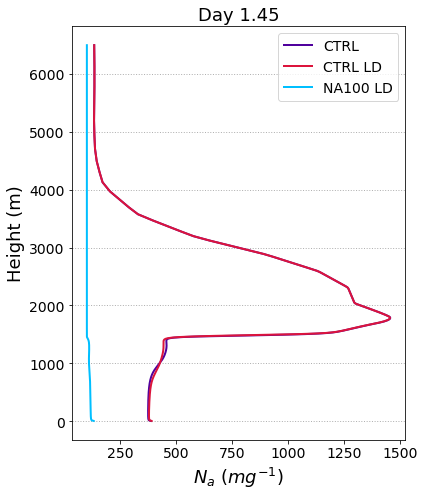

IndexError: index 0 is out of bounds for axis 0 with size 0

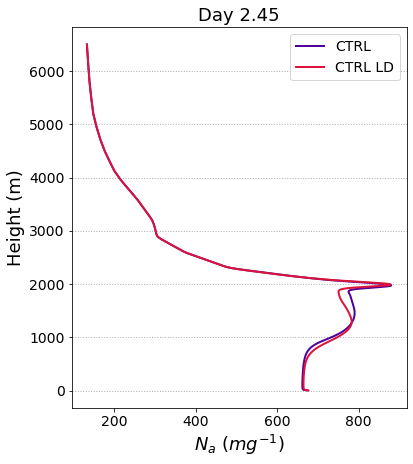

In [15]:
for jjj in [1.5, 2.5, 3.5]:
    fig, axis = plt.subplots(1, 1,figsize=(6,7))

    i = 0
    axis.set_ylabel('Height (m)', fontsize = '18')
    axis.set_xlabel('$N_a$ ($mg^{-1}$)', fontsize = '18')
    #    axis.set_xlim([-700, 700])
    #    axis.set_ylim([0, ylim])
    axis.tick_params(axis='both', which='major', labelsize=14)
    axis.grid(linestyle=':', axis='y', linewidth=1)


    for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
                acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
                height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
                LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])

        z     = fn[jj].variables['z'][:]
        id_t = np.where(np.round(time, 1) == jjj)[0][0]
        NA_m = np.nanmean(NA[id_t-5:id_t+6], 0)

        axis.set_title('Day ' + str(round(time[id_t],2)), fontsize=18 )
        axis.plot(NA_m, z, linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis.legend(fontsize = '14')#, bbox_to_anchor=(1, 0.5))#, loc='upper right')

    plt.tight_layout(w_pad=1)
    plt.show()

### Calculate proper mass flux for the prescription of constant mass and number

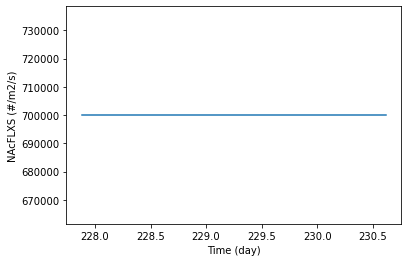

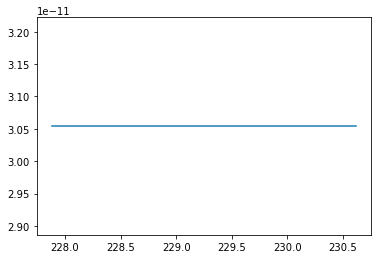

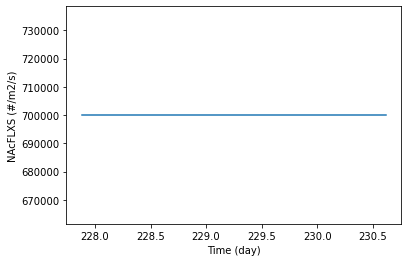

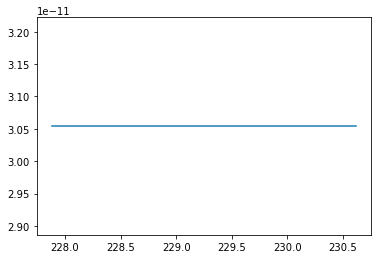

In [4]:
Numb = file.variables['NAcFLXS'][:] # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
masb = file.variables['QAcFLXS'][:] # Subgrid flux of DRY AEROSOL mass
time = file.variables['time'][:] # Subgrid flux of DRY AEROSOL mass
z    = file.variables['z'][:] # Subgrid flux of DRY AEROSOL mass
RHO  = file.variables['RHO'][:]      # kg/m3

plt.figure()
plt.plot(time, Numb[:,0])
plt.xlabel('Time (day)')
plt.ylabel('NAcFLXS (#/m2/s)')

plt.figure()
plt.plot(time, masb[:,0])
plt.xlabel('Time (day)')
plt.ylabel('QAcFLXS')

#################
Numb = file1.variables['NAcFLXS'][:] # Subgrid flux of DRY AEROSOL NUMBER CONCENTRATION: #/m2/s
masb = file1.variables['QAcFLXS'][:] # Subgrid flux of DRY AEROSOL mass
time = file1.variables['time'][:] # Subgrid flux of DRY AEROSOL mass
z    = file1.variables['z'][:] # Subgrid flux of DRY AEROSOL mass
RHO  = file1.variables['RHO'][:]      # kg/m3

plt.figure()
plt.plot(time, Numb[:,0])
plt.xlabel('Time (day)')
plt.ylabel('NAcFLXS (#/m2/s)')

plt.figure()
plt.plot(time, masb[:,0])
plt.xlabel('Time (day)')
plt.ylabel('QAcFLXS')

#### Calculate aerosol radius for variable mass and number fluxes

In [5]:
rho_aerosol = 1769 #; %% This value suggested by Michael.  1300;
rm0 = 92.5e-9 #; %% This is radius. diameter = 185.e-9;
sg0 = 0.2 #;
aer_size = ( (masb[:,0] / (Numb[:,0] / RHO[:,0]) ) / ( (4 * np.pi / 3) * rho_aerosol * np.exp( (9/2) * np.log10(sg0) ** 2 ) ) ) ** (1/3)
aer_size[:10] * 1e9 

masked_array(data=[92.499954, 92.499954, 92.499954, 92.499954, 92.499954,
                   92.499954, 92.499954, 92.499954, 92.499954, 92.499954],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

#### Calculate aerosol radius for constant mass and number fluxes

In [6]:
## First, mass flux:
rho_air  = 1.2112887  # from SEA STARR test
flux_before_rho = 70 * 1e4
fluxNad0 =  flux_before_rho / rho_air # from cm-2 s-1 to kg-1 s-1
rho_aerosol = 1769  
rm0 = 92.5e-9
sg0 = 0.2

fluxQAd0 = fluxNad0 * (4 * np.pi / 3) * rm0 ** 3 * rho_aerosol * np.exp( (9/2) * np.log10(sg0) ** 2 )
fluxQAd0

3.054184688569818e-11

In [7]:
## Then, aerosol size
1e9 * ( ( fluxQAd0 / ( flux_before_rho / RHO[0,0]) ) / ( (4 * np.pi / 3) * rho_aerosol * np.exp( (9/2) * np.log10(sg0) ** 2 ) ) ) ** (1/3)

92.49999975988365

### Triple FT Na in forcing file for the purpose of testing radiative effect of aerosols

In [44]:
##### read various files and variables
## obs and reanalysis
forcing  = Dataset('../SEA_STARR_FAST/SEA_STARR_FAST_SCM_driver_SCAMIOP_Created_14-Jun-2022_TripleFTNa.nc', mode='r+')

## variables in the forcing file:
day   = forcing.variables['day'][:] 
calday= forcing.variables['calday'][:] 
lat   =  forcing.variables['lat'][:]           # Surface Latent Heat Flux:
qref  = forcing.variables['qref'][:] * 1000    # Water Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
qt_fo = forcing.variables['q'][:] * 1000       # Total Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
Tref  = forcing.variables['Tref'][:]           # Absolute Temperature          from from ERA-5: K
SST_fo= forcing.variables['Tg'][:]             # Surface Temperature (SST if over water): K
u_fo  = forcing.variables['u'][:]              # Zonal Wind: m/s
v_fo  = forcing.variables['v'][:]              # Meridional Wind: m/s
z_forc=  forcing.variables['z'][:]             # Geopotential height from ERA-5:
Na_accm= forcing.variables['Na_accum'][:]      # Accumulation mode aerosol number mixing ratio from MERRA2 (Corrected based on regression w/in situ CSET data)
omega =  forcing.variables['omega'][:]         # Vertical Pressure Velocity: Pa/s
fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z_forc[0,:,0,0], fday) # making meshgrid

In [45]:
dayinit  = 228.5
z_1      = 1550
z_2      = 6450
idx_t    = np.where( abs(calday - dayinit) == np.nanmin( abs(calday - dayinit) ) )[0][0]
z_forc_t = z_forc[idx_t,:,0,0]
idx_z1    = np.where( abs(z_forc_t - z_1) == np.nanmin( abs(z_forc_t - z_1) ) )[0][0]
idx_z2    = np.where( abs(z_forc_t - z_2) == np.nanmin( abs(z_forc_t - z_2) ) )[0][0]

Na_accm[:,idx_z2:idx_z1+1,:,:] = Na_accm[:,idx_z2:idx_z1+1,:,:] * 3
forcing.variables['Na_accum'][:] = Na_accm
forcing.close()

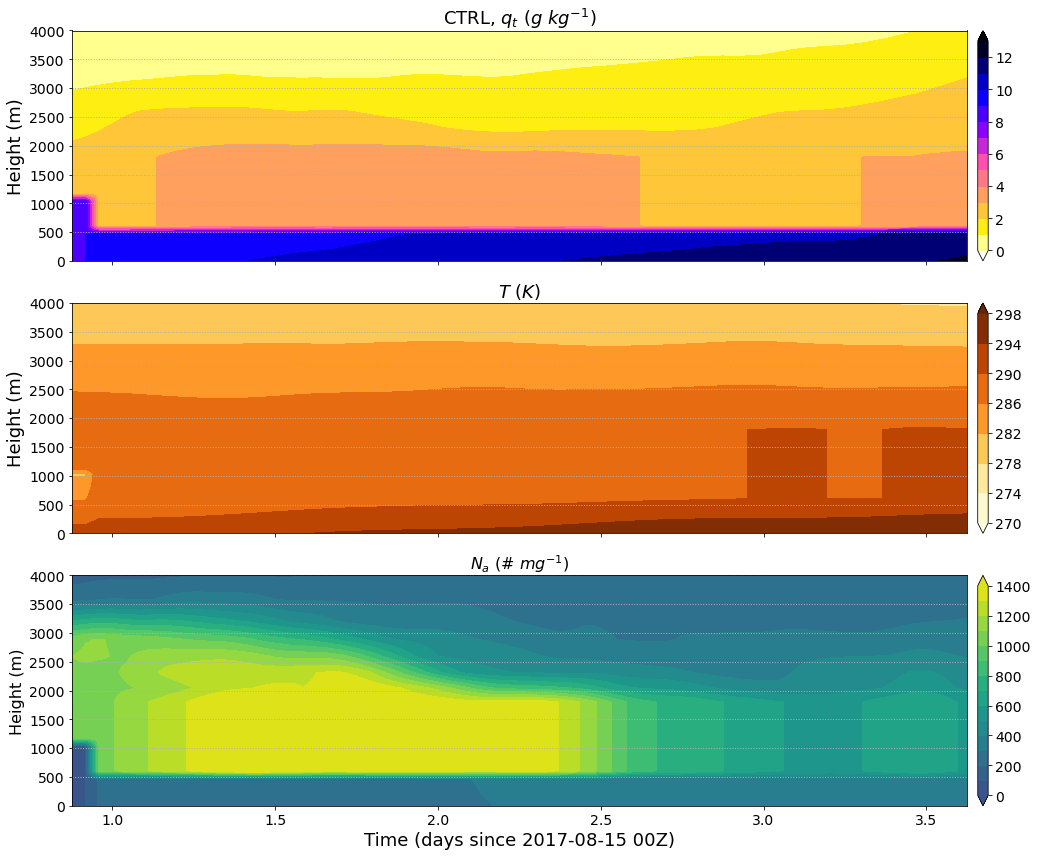

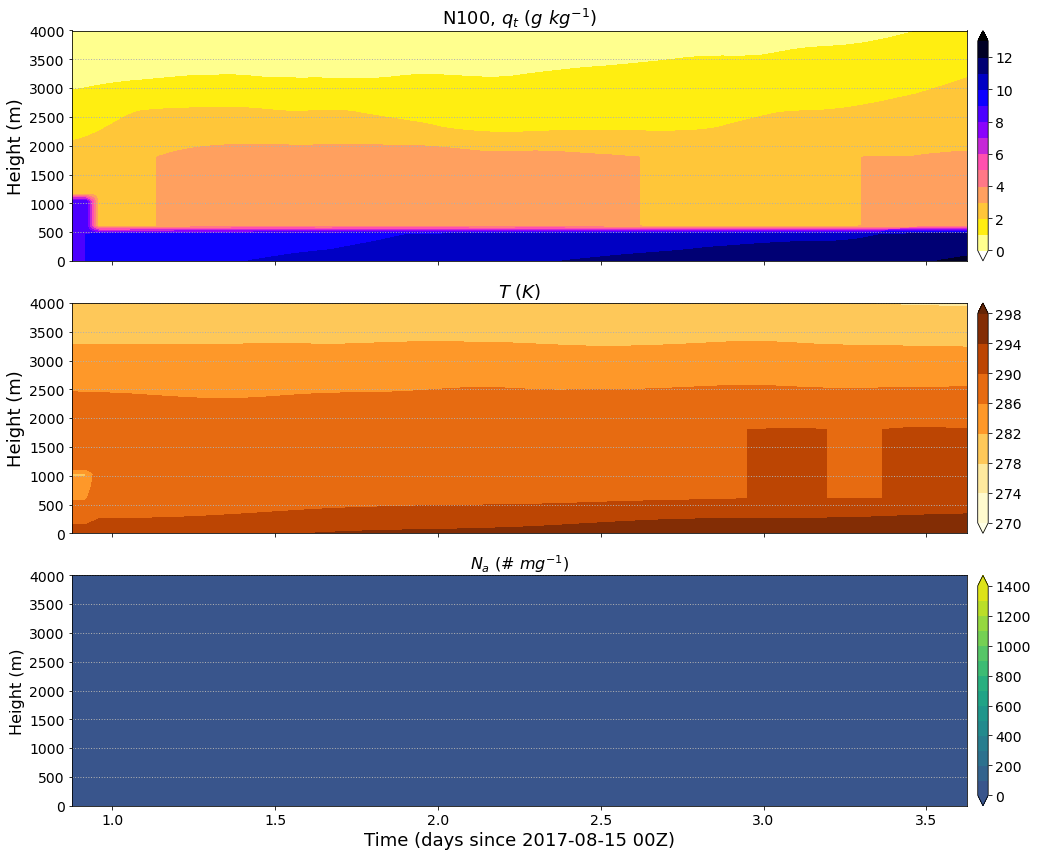

In [14]:
forcing1  = Dataset('../SEA_STARR_FAST/SEA_STARR_CTRL_SCM_driver_SCAMIOP_Created_20-Jun-2022.nc')
forcing2  = Dataset('../SEA_STARR_FAST/SEA_STARR_N100_SCM_driver_SCAMIOP_Created_20-Jun-2022.nc')
forcing   = [forcing1, forcing2]
forc_name = ['CTRL', 'N100']

for jj in range(len(forcing)):

    ## variables in the forcing[jj] file:
    day   = forcing[jj].variables['day'][:] 
    calday= forcing[jj].variables['calday'][:] 
    lat   =  forcing[jj].variables['lat'][:]           # Surface Latent Heat Flux:
    qref  = forcing[jj].variables['qref'][:] * 1000    # Water Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
    qt_fo = forcing[jj].variables['q'][:] * 1000       # Total Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
    Tref  = forcing[jj].variables['Tref'][:]           # Absolute Temperature          from from ERA-5: K
    SST_fo= forcing[jj].variables['Tg'][:]             # Surface Temperature (SST if over water): K
    u_fo  = forcing[jj].variables['u'][:]              # Zonal Wind: m/s
    v_fo  = forcing[jj].variables['v'][:]              # Meridional Wind: m/s
    z_forc=  forcing[jj].variables['z'][:]             # Geopotential height from ERA-5:
    Na_accm= forcing[jj].variables['Na_accum'][:]/1e6  # Accumulation mode aerosol number mixing ratio from MERRA2 (Corrected based on regression w/in situ CSET data)
    omega =  forcing[jj].variables['omega'][:]         # Vertical Pressure Velocity: Pa/s
    fday = calday - int(calday[0])
    dummy, fday_mg = np.meshgrid(z_forc[0,:,0,0], fday) # making meshgrid

    lngh = 15
    box = 5

    cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
    cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

    fig, axis = plt.subplots(3, 1,figsize=(16,12))

    i = 0
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title(forc_name[jj] + ', $q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 1
    axis[i].set_ylabel('Height (m)', fontsize = '18')
    axis[i].set_title('$T$ ($K$)', fontsize = '18')
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    i = 2
    axis[i].set_ylabel('Height (m)', fontsize = '16')
    axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_ylim([0, ylim])    
    axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
    axis[i].tick_params(axis='both', which='major', labelsize=14)
    axis[i].grid(linestyle=':', axis='y', linewidth=1)

    #######
    i = 0
    clevs = np.arange(0, 14, 1)
    ticks = np.arange(0, 14, 2)
    cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], qt_fo[:,:,0,0], clevs, extend='both', cmap = 'gnuplot2_r')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 1
    clevs = np.arange(270, 300.01, 4)
    ticks = np.arange(270, 300.01, 4)
    cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Tref[:,:,0,0], clevs, extend='both', cmap = 'YlOrBr')
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=14)

    i = 2
    clevs = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
    ticks = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
    clevs = [10, 30, 60, 100, 300, 600, 1000]
    ticks = [10, 30, 60, 100, 300, 600, 1000]
    clevs = np.arange(0, 1500, 100)
    cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Na_accm[:,:,0,0], clevs, extend='both', cmap = cmap)#, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
    cb.ax.tick_params(labelsize=14)


    plt.tight_layout(w_pad=1)
    plt.show()

### Test if the forcing file is created correctly

In [64]:
##### read various files and variables
## obs and reanalysis
forcing  = Dataset('../SEA_STARR_FAST/SEA_STARR_FAST_SCM_driver_SCAMIOP_Created_14-Jun-2022_TripleFTNa.nc')

## variables in the forcing file:
day   = forcing.variables['day'][:] 
calday= forcing.variables['calday'][:] 
lat   =  forcing.variables['lat'][:]           # Surface Latent Heat Flux:
qref  = forcing.variables['qref'][:] * 1000    # Water Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
qt_fo = forcing.variables['q'][:] * 1000       # Total Vapor Mass Mixing Ratio from from ERA-5: converted to g/kg
Tref  = forcing.variables['Tref'][:]           # Absolute Temperature          from from ERA-5: K
SST_fo= forcing.variables['Tg'][:]             # Surface Temperature (SST if over water): K
u_fo  = forcing.variables['u'][:]              # Zonal Wind: m/s
v_fo  = forcing.variables['v'][:]              # Meridional Wind: m/s
z_forc=  forcing.variables['z'][:]             # Geopotential height from ERA-5:
Na_accm= forcing.variables['Na_accum'][:]/1e6  # Accumulation mode aerosol number mixing ratio from MERRA2 (Corrected based on regression w/in situ CSET data)
omega =  forcing.variables['omega'][:]         # Vertical Pressure Velocity: Pa/s
fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z_forc[0,:,0,0], fday) # making meshgrid

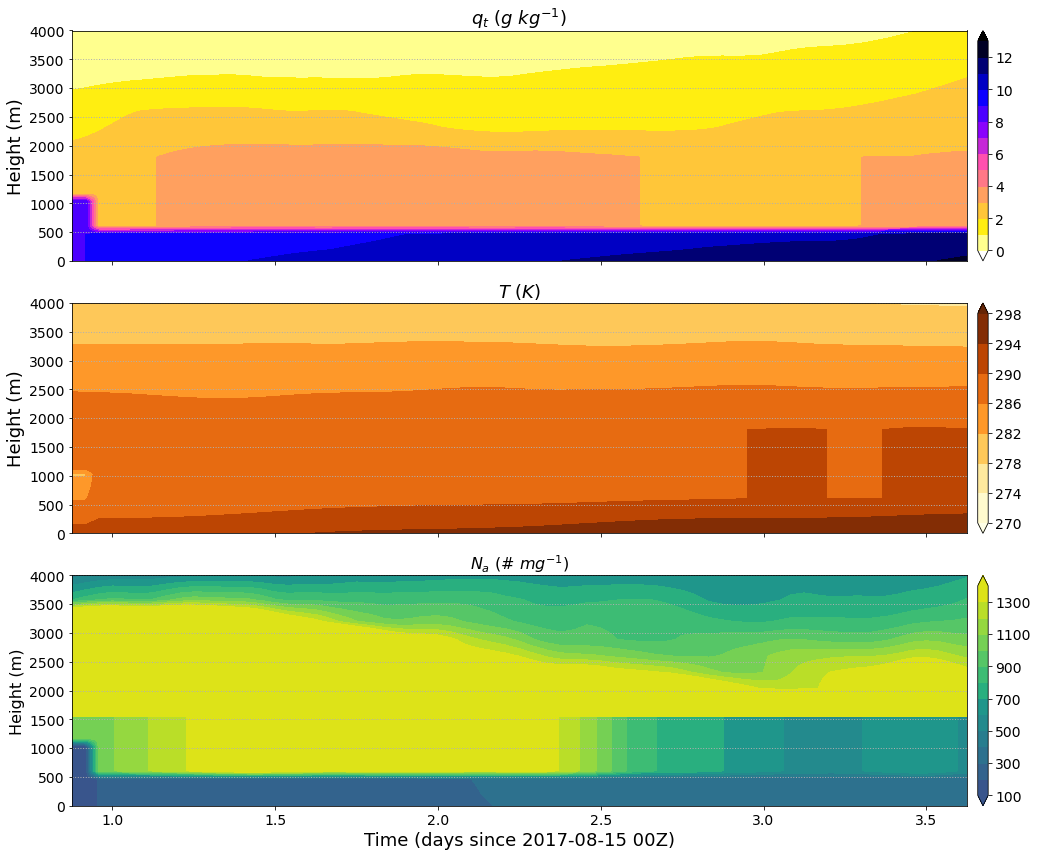

In [67]:
lngh = 15
box = 5

cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

fig, axis = plt.subplots(3, 1,figsize=(16,12))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$T$ ($K$)', fontsize = '18')
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_ylim([0, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(0, 14, 1)
ticks = np.arange(0, 14, 2)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], qt_fo[:,:,0,0], clevs, extend='both', cmap = 'gnuplot2_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(270, 300.01, 4)
ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Tref[:,:,0,0], clevs, extend='both', cmap = 'YlOrBr')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
ticks = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
clevs = [10, 30, 60, 100, 300, 600, 1000]
ticks = [10, 30, 60, 100, 300, 600, 1000]
clevs = np.arange(100, 1500, 100)
cc1 = axis[i].contourf(fday_mg, z_forc[:,:,0,0], Na_accm[:,:,0,0], clevs, extend='both', cmap = cmap)#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)

plt.tight_layout(w_pad=1)
plt.show()

(0.0, 3500.0)

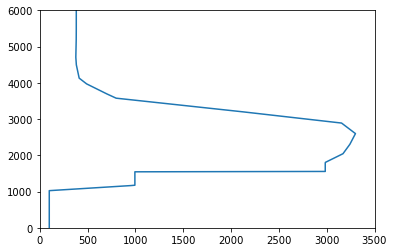

In [60]:
plt.plot(Na_accm[0,:,0,0],z_forc[0,:,0,0])
plt.ylim([0, 6000])
plt.xlim([0, 3500])

(0.0, 3500.0)

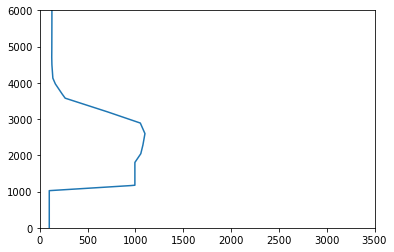

In [63]:
plt.plot(Na_accm[0,:,0,0],z_forc[0,:,0,0])
plt.ylim([0, 6000])
plt.xlim([0, 3500])

## Previous tests

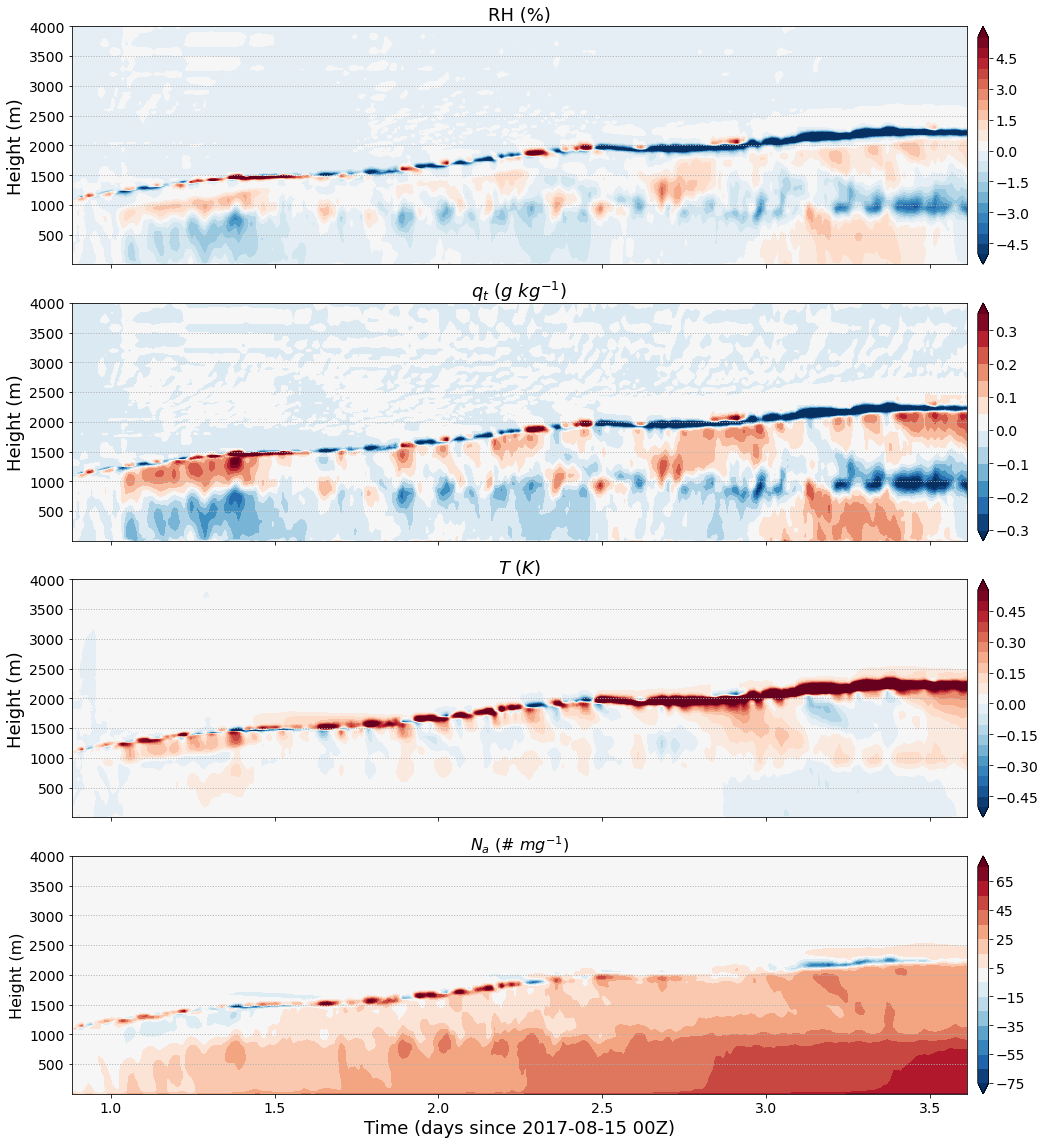

In [39]:
def calc_interp_var(time1, time, var1, var): #   z, RHO, MERRA_H, iii):
    out = var.copy()
    out[:] = np.nan    
    for i in range(out.shape[1]):
        f = interpolate.interp1d(time1, var1[:,i], fill_value="extrapolate")
#         indx2 = np.where(MERRA_H[i,:] > z.max())[0]
#         if len(indx2) > 0:
#             indx = indx2[-1]
#             Forcing_RHO[i, indx+1:] = f_RHO(np.array(MERRA_H[i, indx+1:]))
#             Forcing_RHO[i, :indx+1] = Forcing_RHO[i, indx+1]
#         else:
        out[:,i] = f(np.array(time[:]))
    return out



time, z, dz, RHO, CWP, RWP, ISccPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

lngh = 15
box = 5


cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])


#######
    
    
fig, axis = plt.subplots(4, 1,figsize=(16,16))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('RH (%)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([start, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([start, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$T$ ($K$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([start, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 3
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$N_a$ (# $mg^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([start, ylim])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

for jj in range(len(fn)):

    time, z, dz, RHO, CWP, RWP, ISccPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
    if jj == 0: 
        RH1   = RH.copy()
        QT1   = QT.copy()
        TABS1 = TABS.copy()
        NA1   = NA.copy()
        time1 = time.copy()
        
    elif jj == 1:
        RH1_intrp   = calc_interp_var(time1, time, RH1, RH)
        QT1_intrp   = calc_interp_var(time1, time, QT1, RH)
        TABS1_intrp = calc_interp_var(time1, time, TABS1, RH)
        NA1_intrp   = calc_interp_var(time1, time, NA1, RH)
        RH2   = RH.copy()
        QT2   = QT.copy()
        TABS2 = TABS.copy()
        NA2   = NA.copy()
        

    z_mg, time_mg = np.meshgrid(z, time) # making meshgrid

i = 0
clevs = np.arange(-5, 6, .5)
cc1 = axis[i].contourf(time_mg, z_mg, RH2 - RH1_intrp, clevs, extend='both', cmap = 'RdBu_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-.3, .4, .05)
cc1 = axis[i].contourf(time_mg, z_mg, QT2 - QT1_intrp, clevs, extend='both', cmap = 'RdBu_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = np.arange(-.5, .6, .05)
cc1 = axis[i].contourf(time_mg, z_mg, TABS2 - TABS1_intrp, clevs, extend='both', cmap = 'RdBu_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 3
clevs = np.arange(-75, 85, 10)
cc1 = axis[i].contourf(time_mg, z_mg, NA2 - NA1_intrp, clevs, extend='both', cmap = 'RdBu_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

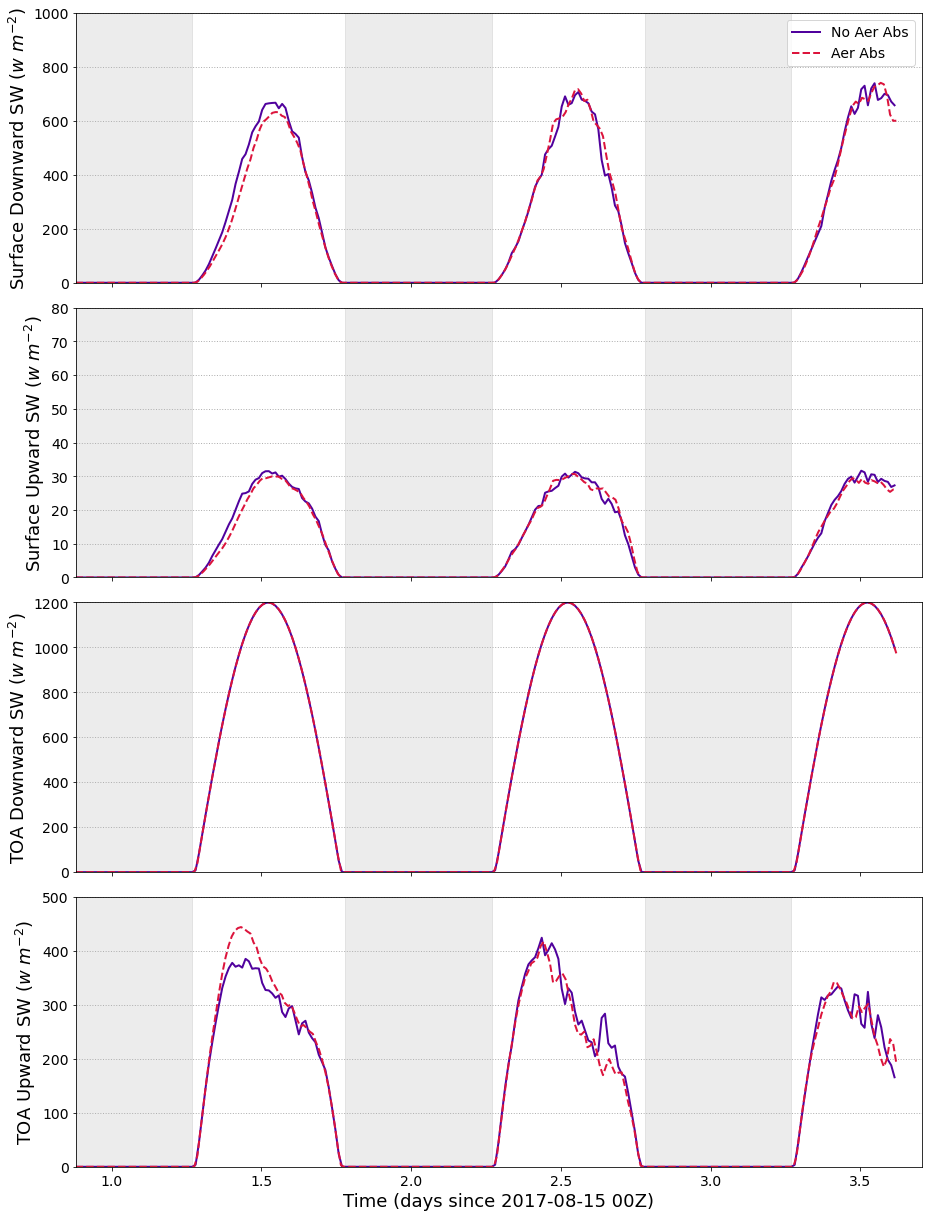

In [27]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 40
box = 10
ERA_c = 'orange'

####
fig, axis = plt.subplots(4, 1,figsize=(13,17))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Surface Downward SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 1000])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Surface Upward SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 80])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('TOA Downward SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 1200])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 3
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('TOA Upward SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 500])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


    ###
for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
        
        SWNS    = fn[jj].variables['SWNS'][:]
        SWDS    = fn[jj].variables['SWDS'][:]
        SWNTOA  = fn[jj].variables['SWNTOA'][:]
        SOLIN   = fn[jj].variables['SOLIN'][:]
        SWUS    = SWDS - SWNS
        SWUTOA  = SOLIN - SWNTOA
        
        i = 0
        axis[i].plot(time, SWDS, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis[i].legend(fontsize = '14', loc='upper right')
        i = 1
        axis[i].plot(time, SWUS, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 2
        axis[i].plot(time, SOLIN, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 3
        axis[i].plot(time, SWUTOA, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])

        
plt.tight_layout(w_pad=1)
plt.show()

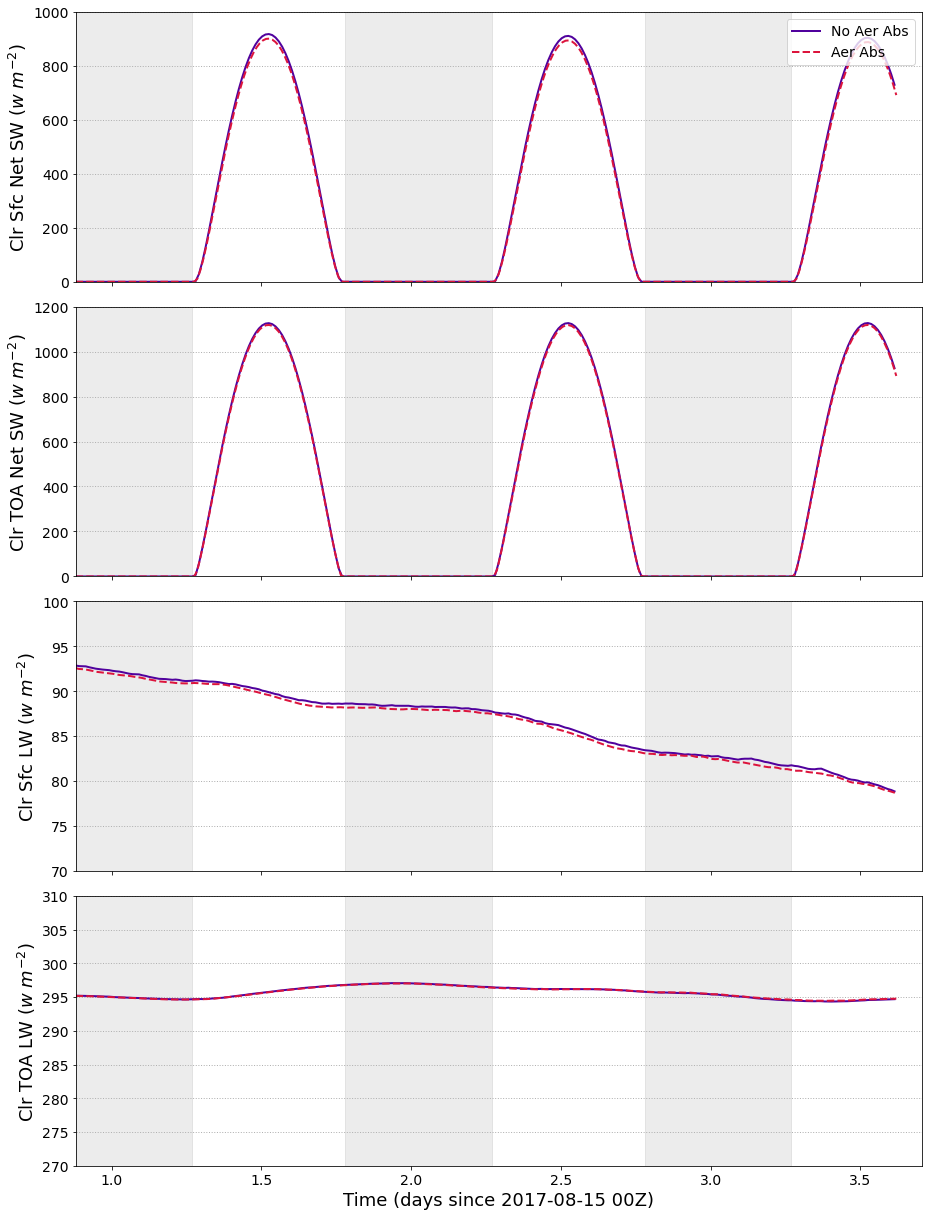

In [36]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 40
box = 10
ERA_c = 'orange'

####
fig, axis = plt.subplots(4, 1,figsize=(13,17))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Clr Sfc Net SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 1000])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Clr TOA Net SW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 1200])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Clr Sfc LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([70, 100])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 3
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Clr TOA LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([270, 310])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


    ###
for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
        
        SWNSC   = fn[jj].variables['SWNSC'][:]
        SWNTOAC = fn[jj].variables['SWNTOAC'][:]
        LWNSC   = fn[jj].variables['LWNSC'][:]
        LWNTOAC = fn[jj].variables['LWNTOAC'][:]

        i = 0
        axis[i].plot(time, SWNSC, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis[i].legend(fontsize = '14', loc='upper right')
        i = 1
        axis[i].plot(time, SWNTOAC, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 2
        axis[i].plot(time, LWNSC, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 3
        axis[i].plot(time, LWNTOAC, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])

        

plt.tight_layout(w_pad=1)
plt.show()


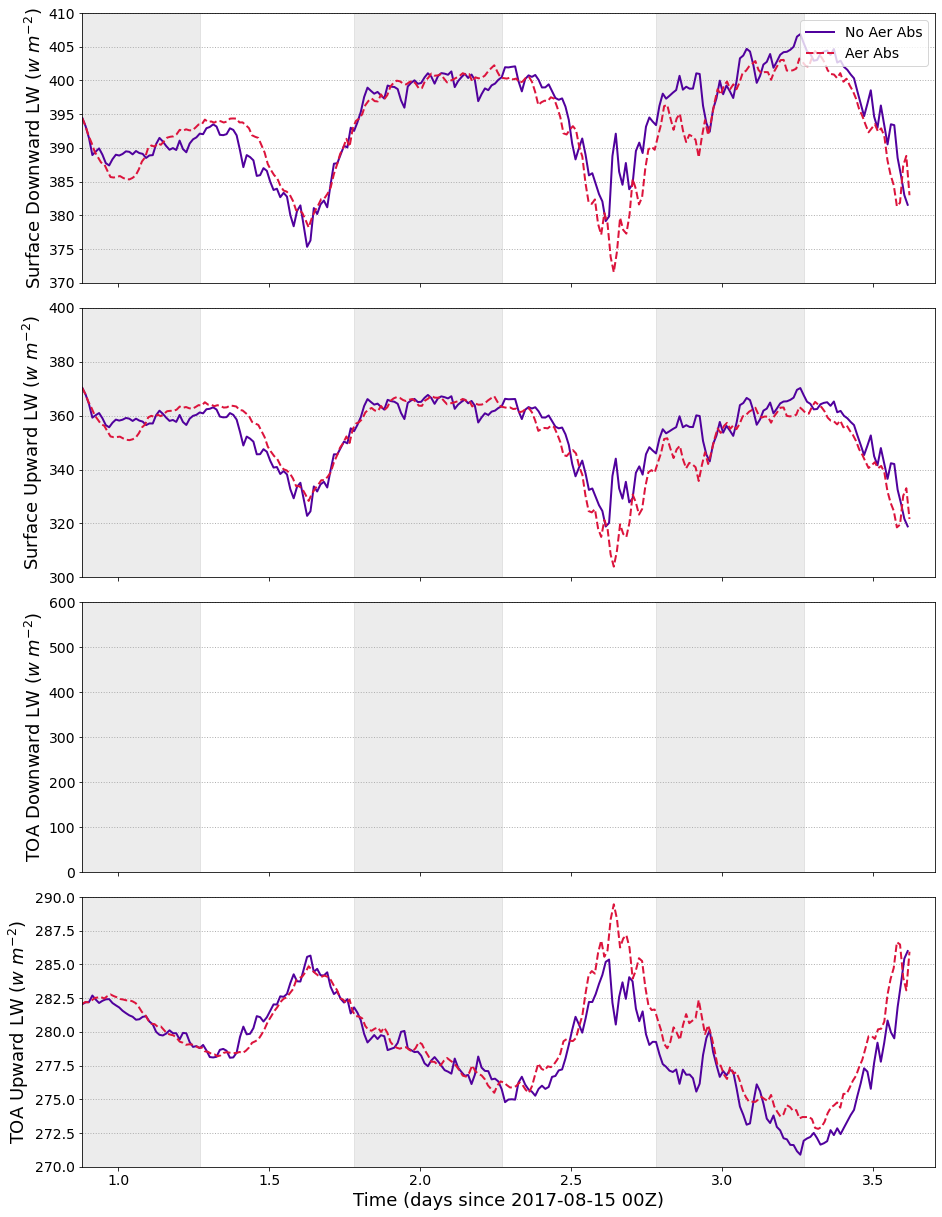

In [61]:
time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, SWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, SW_CRE, SWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[0])

lngh = 40
box = 10
ERA_c = 'orange'

####
fig, axis = plt.subplots(4, 1,figsize=(13,17))

i = 0
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Surface Downward LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([370, 410])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 1
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('Surface Upward LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([300, 400])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 2
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('TOA Downward LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([0, 600])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].axes.get_xaxis().set_ticklabels([])

i = 3
axis[i].fill_between(time, -upbound, upbound, color='k', alpha=.075)
axis[i].set_ylabel('TOA Upward LW ($w$ $m^{-2}$)', fontsize = '18')
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].set_xlim([start, xlim + xlim / lngh])
axis[i].set_ylim([270, 290])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


    ###
for jj in range(len(fn)):
        time, z, dz, RHO, CWP, RWP, ISCCPTOT, ZINV, entr, LWNTOA, LWNS, P, TABS, inv_idx, W2_Zinv_200,\
            acc_prec, THETA, QT, integ_NA_BL, integ_NC_BL, COD, SAM_re, height_NARC, height_ENTRNMT, height_NASURF,\
            height_NPRA, height_NASED, height_NASCAV, sfc_wnd, albedo, NA, NC, PREC, RH, albd_clear, SOLIN2, LW_CRE, LWNTOAC, \
            LHF, SHF, WOBS, U, V, SST = read_model_vars(fn[jj])
        
        LWNT    = fn[jj].variables['LWNS'][:]
        LWDS    = fn[jj].variables['LWDS'][:]
        LWNTOA  = fn[jj].variables['LWNTOA'][:]
        LWUS    = LWDS - LWNT
        LWUTOA  = LWNTOA
        

        i = 0
        axis[i].plot(time, LWDS, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        axis[i].legend(fontsize = '14', loc='upper right')
        i = 1
        axis[i].plot(time, LWUS, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 2
#        axis[i].plot(time, SOLIN, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])
        i = 3
        axis[i].plot(time, LWUTOA, ls[jj], linewidth= lw[jj], color=cc[jj], label=lb[jj])

        

plt.tight_layout(w_pad=1)
plt.show()
